In [9]:
#### ============================================================================
# ATP Tennis Player Development - Multi-Class Tier Prediction
# ============================================================================
"""
Project: Predicting tennis player development trajectories

Problem Evolution:
- Initial: Binary classification (top 50 vs rest) → 3% positive cases, weak signal
- Discovery: Investigation revealed gradient - 17% reached top 150, 59% improved 100+ spots  
- Solution: Multi-class classification capturing 4 development tiers

Tiers:
4 - Breakthrough (0-99): 10 players
3 - Rising (100-199): 54 of players
2 - Challenger (200-299): 58 players
1 - No Progress (300+): 171 players

Features: Performance vs higher-ranked opponents + win consistency
Timeline: 2021 features → 2022-2023 outcomes
"""

# Imports
import pandas as pd
import numpy as np
import sqlite3
import matplotlib as pl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from platform import python_version

import warnings
import logging

# Suppress matplotlib font warnings
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')
logging.getLogger('matplotlib').setLevel(logging.ERROR)

# Set random seed for reproducibility
np.random.seed(42)

print("✅ Libraries loaded")
print("📊 Ready to build multi-class tier prediction model")

✅ Libraries loaded
📊 Ready to build multi-class tier prediction model


In [2]:
# ============================================================================
# SECTION 1: Data Loading & Setup
# ============================================================================

# Load feature data
df = pd.read_csv('tennis_breakthrough_dataset.csv')
print(f"Loaded features for {len(df)} players")

# Connect to database for ranking outcomes
conn = sqlite3.connect('tennis_breakthrough.db')

# Get player outcomes (from previous investigation)
player_ids_str = ','.join(map(str, df['player_id'].tolist()))

# Step 1: Get baseline rankings (July 2021) for our 293 players
print("\n📊 Step 1: Getting July 2021 baseline rankings...")
print("-"*80)

inital_query = f"""
SELECT 
    player_id,
    MIN(rank) as baseline_rank,
    ranking_date as baseline_date
FROM rankings
WHERE ranking_date BETWEEN 20210901 AND 20210931
  AND player_id IN ({player_ids_str})
GROUP BY player_id
"""

baseline_df = pd.read_sql_query(inital_query, conn)

print(f"Found inital rankings for {len(baseline_df)} players")
print(f"\nInital ranking stats:")
print(baseline_df['baseline_rank'].describe())

# Step 2: Get best ranking achieved (Jan 2022 - July 2023)
print("\n📊 Step 2: Getting best rankings achieved Jan 2022 - Jan 2023...")
print("-"*80)

best_rank_query = f"""
SELECT 
    player_id,
    MIN(rank) as best_rank,
    ranking_date as date_of_best_rank
FROM rankings
WHERE ranking_date BETWEEN 20220101 AND 20230101
  AND player_id IN ({player_ids_str})
GROUP BY player_id
"""

best_rank_df = pd.read_sql_query(best_rank_query, conn)
print(f"Found best rankings for {len(best_rank_df)} players")
print(f"\nBest ranking stats:")
print(best_rank_df['best_rank'].describe())

# Step 3: Merge and calculate ranking improvement
print("\n📊 Step 3: Calculating ranking improvements...")
print("-"*80)

ranking_outcomes = baseline_df.merge(best_rank_df, on='player_id', how='left')

# Calculate improvement (positive = better, negative = worse)
ranking_outcomes['ranking_improvement'] = ranking_outcomes['baseline_rank'] - ranking_outcomes['best_rank']

# Handle players with no future ranking data (retired/inactive)
missing_future = ranking_outcomes['best_rank'].isna().sum()
if missing_future > 0:
    print(f"⚠️  {missing_future} players have no ranking data in 2022-2023 (retired/inactive)")
    ranking_outcomes['best_rank'].fillna(ranking_outcomes['baseline_rank'], inplace=True)
    ranking_outcomes['ranking_improvement'].fillna(0, inplace=True)

print(f"\nRanking improvement stats:")
print(ranking_outcomes['ranking_improvement'].describe())


# Merge with original dataset
df_with_outcomes = df.merge(ranking_outcomes[['player_id', 'baseline_rank', 'best_rank', 'ranking_improvement']], 
                             on='player_id', how='left')

Loaded features for 293 players

📊 Step 1: Getting July 2021 baseline rankings...
--------------------------------------------------------------------------------
Found inital rankings for 293 players

Inital ranking stats:
count     293.000000
mean      525.252560
std       253.539663
min        62.000000
25%       320.000000
50%       534.000000
75%       673.000000
max      2098.000000
Name: baseline_rank, dtype: float64

📊 Step 2: Getting best rankings achieved Jan 2022 - Jan 2023...
--------------------------------------------------------------------------------
Found best rankings for 293 players

Best ranking stats:
count     293.000000
mean      392.119454
std       224.702336
min        10.000000
25%       220.000000
50%       350.000000
75%       534.000000
max      1238.000000
Name: best_rank, dtype: float64

📊 Step 3: Calculating ranking improvements...
--------------------------------------------------------------------------------

Ranking improvement stats:
count     293

🎯 MULTI-CLASS TARGET VARIABLE

📊 Tier Distribution (Matching Previous Model):
--------------------------------------------------------------------------------
  No_Progress     (Tier 0): 171 players ( 58.4%) █████████████████████████████
  Challenger      (Tier 1):  58 players ( 19.8%) █████████
  Rising          (Tier 2):  54 players ( 18.4%) █████████
  Breakthrough    (Tier 3):  10 players (  3.4%) █

✅ Total: 293 players assigned
✅ No missing values in tier_numeric

✅ Target variable created: tier_numeric (0-3)
   0 = No_Progress | 1 = Challenger | 2 = Rising | 3 = Breakthrough

🔥 CORRELATION ANALYSIS: Did the Pivot Improve Predictive Signal?

📊 CORRELATION COMPARISON:
--------------------------------------------------------------------------------
        Feature  Old_Binary_Corr  New_MultiClass_Corr  Improvement
    win25_count         0.106226             0.304564     0.198338
win_rate_4month         0.167492             0.286807     0.119315
     win25_rate         0.073484    

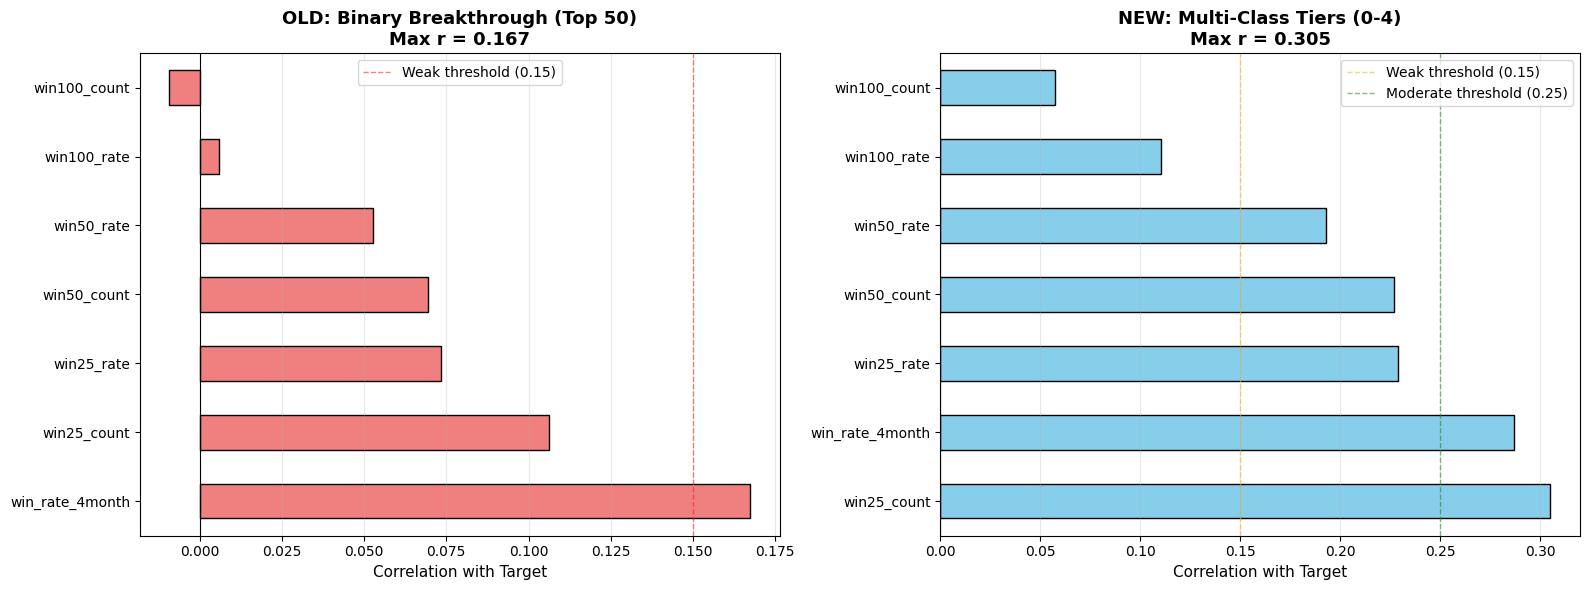


✅ DECISION: Signal improved! Proceed with modeling.
   Best feature (win25_count) shows moderate-to-strong correlation.


In [3]:
# ============================================================================
# SECTION 2: Create Multi-Class Target & Correlation Analysis
# ============================================================================

print("="*80)
print("🎯 MULTI-CLASS TARGET VARIABLE")
print("="*80)

# Create tier assignment function
def assign_tier(best_rank):
    if best_rank <= 100:
        return 3  #Breakthrough
    elif best_rank <= 200:
        return 2  # Breakthrough
    elif best_rank <= 300:
        return 1  # Challenger
    else:
        return 0  # No Progress 

# Create numeric tier for modeling
df_with_outcomes['tier_numeric'] = df_with_outcomes['best_rank'].apply(assign_tier)

# Encode numerically
tier_names = {
    0: 'No_Progress',
    1: 'Challenger',
    2: 'Rising',
    3: 'Breakthrough'
}

df_with_outcomes['tier_label'] = df_with_outcomes['tier_numeric'].map(tier_names)

print("\n📊 Tier Distribution (Matching Previous Model):")
print("-"*80)

for tier_code in [0, 1, 2, 3]:
    tier_name = tier_names[tier_code]
    count = (df_with_outcomes['tier_numeric'] == tier_code).sum()
    pct = 100 * count / len(df_with_outcomes)
    bar = '█' * int(pct / 2)
    print(f"  {tier_name:15s} (Tier {tier_code}): {count:3d} players ({pct:5.1f}%) {bar}")

total = len(df_with_outcomes)
print(f"\n✅ Total: {total} players assigned")

# Verify no missing values
missing = df_with_outcomes['tier_numeric'].isna().sum()
if missing > 0:
    print(f"⚠️  Warning: {missing} players with missing tier")
else:
    print(f"✅ No missing values in tier_numeric")

print("\n" + "="*80)
print("✅ Target variable created: tier_numeric (0-3)")
print("   0 = No_Progress | 1 = Challenger | 2 = Rising | 3 = Breakthrough")
print("="*80)

# ============================================================================
# THE CRITICAL QUESTION: Did Signal Improve?
# ============================================================================

print("\n" + "="*80)
print("🔥 CORRELATION ANALYSIS: Did the Pivot Improve Predictive Signal?")
print("="*80)

features = ['win25_count', 'win25_rate', 'win50_count', 'win50_rate', 
            'win100_count', 'win100_rate', 'win_rate_4month']

# Calculate correlations with new multi-class target
tier_correlations = df_with_outcomes[features].corrwith(df_with_outcomes['tier_numeric']).sort_values(ascending=False)

# Compare to old binary target
old_correlations = df_with_outcomes[features].corrwith(df_with_outcomes['breakthrough']).sort_values(ascending=False)

# Create comparison table
comparison_df = pd.DataFrame({
    'Feature': features,
    'Old_Binary_Corr': [old_correlations[f] for f in features],
    'New_MultiClass_Corr': [tier_correlations[f] for f in features],
    'Improvement': [tier_correlations[f] - old_correlations[f] for f in features]
}).sort_values('New_MultiClass_Corr', ascending=False)

print("\n📊 CORRELATION COMPARISON:")
print("-"*80)
print(comparison_df.to_string(index=False))

print("\n⚖️  SUMMARY:")
print("-"*80)
print(f"OLD (Binary top 50):     Max correlation = {old_correlations.max():.4f} ({old_correlations.idxmax()})")
print(f"NEW (Multi-class tiers): Max correlation = {tier_correlations.max():.4f} ({tier_correlations.idxmax()})")
print(f"Improvement: {tier_correlations.max() - old_correlations.max():+.4f}")

# Visualize the comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Old correlations
old_correlations.plot(kind='barh', ax=ax1, color='lightcoral', edgecolor='black')
ax1.set_title('OLD: Binary Breakthrough (Top 50)\nMax r = 0.167', 
              fontsize=13, fontweight='bold')
ax1.set_xlabel('Correlation with Target', fontsize=11)
ax1.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax1.axvline(x=0.15, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Weak threshold (0.15)')
ax1.grid(axis='x', alpha=0.3)
ax1.legend()

# New correlations
tier_correlations.plot(kind='barh', ax=ax2, color='skyblue', edgecolor='black')
ax2.set_title(f'NEW: Multi-Class Tiers (0-4)\nMax r = {tier_correlations.max():.3f}', 
              fontsize=13, fontweight='bold')
ax2.set_xlabel('Correlation with Target', fontsize=11)
ax2.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax2.axvline(x=0.15, color='orange', linestyle='--', linewidth=1, alpha=0.5, label='Weak threshold (0.15)')
ax2.axvline(x=0.25, color='green', linestyle='--', linewidth=1, alpha=0.5, label='Moderate threshold (0.25)')
ax2.grid(axis='x', alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

# Decision point
if tier_correlations.max() > 0.20:
    print("\n✅ DECISION: Signal improved! Proceed with modeling.")
    print(f"   Best feature ({tier_correlations.idxmax()}) shows moderate-to-strong correlation.")
elif tier_correlations.max() > old_correlations.max():
    print("\n⚠️  DECISION: Signal improved slightly but still weak.")
    print("   We can proceed with modeling but should manage expectations.")
else:
    print("\n❌ DECISION: Signal did not improve.")
    print("   May need feature engineering or this is just a hard problem.")

🔧 FEATURE ENGINEERING: Performance + Demographics + Match Psychology

📊 Part 1: Adding demographic features...
Found demographics for 293 players
✅ Added: age_in_2021, is_lefty, height_cm, from_top_nation

📊 Part 2: Creating match psychology features (duration-based)...
Found 2438 matches with duration data
✅ Added: avg_win_duration, avg_loss_duration, fight_score, dominance_score
   Players with psychology data: 189/293

📊 Part 3: Creating performance interaction features...
✅ Added: 8 performance interaction/ratio features

🎉 FEATURE ENGINEERING COMPLETE!
Total features now: 34

Feature categories:
  • Original performance: 7 features
  • Performance engineered: 8 features
  • Demographics: 4 features
  • Match psychology: 4 features
  • TOTAL NEW: 16 features

🔥 CORRELATION ANALYSIS: Did Feature Engineering Work?

📊 TOP 15 FEATURES BY CORRELATION:
--------------------------------------------------------------------------------
 1. volume_dominance         : +0.4779  🔥 🔧 Engineered
 

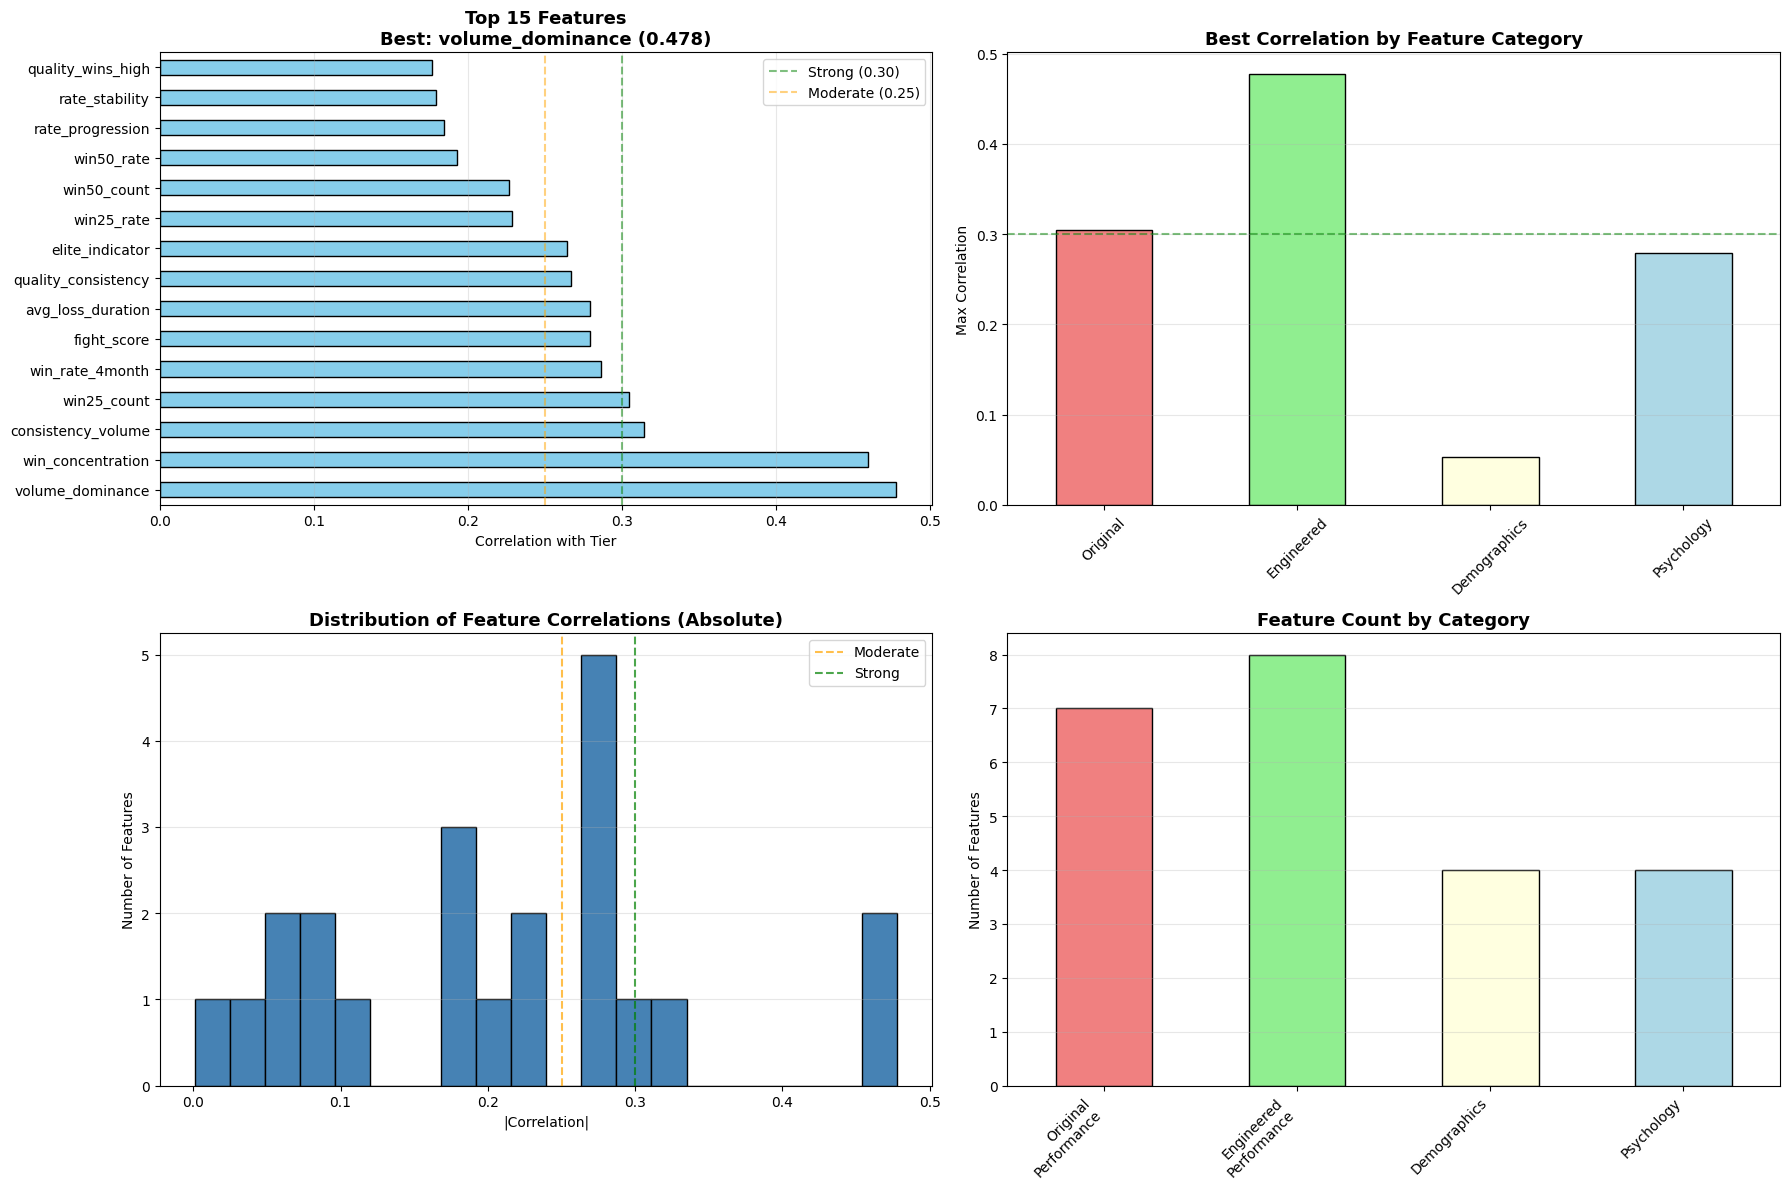


✅ Feature engineering and analysis complete!


In [ ]:
# ============================================================================
# SECTION 3: Comprehensive Feature Engineering
# ============================================================================

print("="*80)
print("🔧 FEATURE ENGINEERING: Performance + Demographics + Match Psychology")
print("="*80)

# ============================================================================
# Part 1: Add Demographic Features (FIXED - no duplicate columns)
# ============================================================================

print("\n📊 Part 1: Adding demographic features...")

conn = sqlite3.connect('tennis_breakthrough.db')

player_ids = df_with_outcomes['player_id'].tolist()
player_ids_str = ','.join(str(x) for x in player_ids)

demographics_query = f"""
SELECT 
    pid as player_id,
    Birth_Year,
    Nationality,
    Dominant_Hand,
    Height
FROM Players
WHERE pid IN ({player_ids_str})
"""

demographics_df = pd.read_sql_query(demographics_query, conn)
print(f"Found demographics for {len(demographics_df)} players")

# Merge with suffixes to handle any duplicates
df_with_outcomes = df_with_outcomes.merge(
    demographics_df, 
    on='player_id', 
    how='left',
    suffixes=('', '_demo')  # Keep original names, add _demo to duplicates
)

# Create derived demographic features
df_with_outcomes['age_in_2021'] = 2021 - df_with_outcomes['Birth_Year']
df_with_outcomes['is_lefty'] = (df_with_outcomes['Dominant_Hand'] == 'L').astype(int)
df_with_outcomes['height_cm'] = pd.to_numeric(df_with_outcomes['Height'], errors='coerce')

top_nations = ['ESP', 'FRA', 'ITA', 'ARG', 'USA', 'GER', 'RUS', 'AUS']
df_with_outcomes['from_top_nation'] = df_with_outcomes['Nationality'].isin(top_nations).astype(int)

print("✅ Added: age_in_2021, is_lefty, height_cm, from_top_nation")

# ============================================================================
# Part 2: Match Psychology Features (HANDLE EMPTY STRINGS)
# ============================================================================

print("\n📊 Part 2: Creating match psychology features (duration-based)...")

# Get match durations
match_duration_query = f"""
SELECT 
    pid as player_id,
    Won as result,
    duration as minutes
FROM Matches
WHERE Date BETWEEN 20210901 AND 20211231
  AND pid IN ({player_ids_str})
  AND Duration IS NOT NULL
  AND Duration > 0
  AND Duration != ''
"""

match_durations = pd.read_sql_query(match_duration_query, conn)
print(f"Found {len(match_durations)} matches with duration data")

# Build psychology features using basic Python
psych_data = {
    'player_id': [],
    'avg_win_duration': [],
    'avg_loss_duration': [],
    'fight_score': [],
    'dominance_score': []
}

for player_id in df_with_outcomes['player_id'].unique():
    # Get this player's matches
    player_data = match_durations[match_durations['player_id'] == player_id]
    
    if len(player_data) == 0:
        psych_data['player_id'].append(int(player_id))
        psych_data['avg_win_duration'].append(None)
        psych_data['avg_loss_duration'].append(None)
        psych_data['fight_score'].append(None)
        psych_data['dominance_score'].append(None)
        continue
    
    # Convert to lists, filtering out invalid values
    results = []
    durations = []
    
    for _, row in player_data.iterrows():
        try:
            dur = float(row['minutes'])
            if dur > 0:  # Only valid positive durations
                results.append(int(row['result']))
                durations.append(dur)
        except (ValueError, TypeError):
            continue  # Skip invalid data
    
    if len(durations) == 0:
        psych_data['player_id'].append(int(player_id))
        psych_data['avg_win_duration'].append(None)
        psych_data['avg_loss_duration'].append(None)
        psych_data['fight_score'].append(None)
        psych_data['dominance_score'].append(None)
        continue
    
    # Separate wins and losses
    win_durations = [durations[i] for i in range(len(results)) if results[i] == 1]
    loss_durations = [durations[i] for i in range(len(results)) if results[i] == 0]
    
    # Calculate averages
    avg_win = sum(win_durations) / len(win_durations) if len(win_durations) > 0 else None
    avg_loss = sum(loss_durations) / len(loss_durations) if len(loss_durations) > 0 else None
    
    # Store
    psych_data['player_id'].append(int(player_id))
    psych_data['avg_win_duration'].append(avg_win)
    psych_data['avg_loss_duration'].append(avg_loss)
    psych_data['fight_score'].append(avg_loss)
    psych_data['dominance_score'].append(-avg_win if avg_win is not None else None)

# Create DataFrame
psychology_df = pd.DataFrame(psych_data)

# Merge
df_with_outcomes['player_id'] = df_with_outcomes['player_id'].astype(int)
df_with_outcomes = df_with_outcomes.merge(psychology_df, on='player_id', how='left', suffixes=('', '_psych'))

n_with_data = sum(1 for x in psych_data['fight_score'] if x is not None)
print(f"✅ Added: avg_win_duration, avg_loss_duration, fight_score, dominance_score")
print(f"   Players with psychology data: {n_with_data}/{len(df_with_outcomes)}")

conn.close()

# ============================================================================
# Part 3: Performance Interaction Features (from before)
# ============================================================================

print("\n📊 Part 3: Creating performance interaction features...")

# Interaction terms
df_with_outcomes['consistency_volume'] = (
    df_with_outcomes['win25_count'] * df_with_outcomes['win_rate_4month']
)

df_with_outcomes['quality_consistency'] = (
    df_with_outcomes['win25_rate'] * df_with_outcomes['win_rate_4month']
)

# Ratio features
df_with_outcomes['win_concentration'] = (
    df_with_outcomes['win25_count'] / (df_with_outcomes['win100_count'] + 1)
)

df_with_outcomes['rate_progression'] = (
    df_with_outcomes['win25_rate'] / (df_with_outcomes['win100_rate'] + 0.01)
)

# Threshold features
df_with_outcomes['elite_indicator'] = (
    (df_with_outcomes['win25_count'] >= 7) & 
    (df_with_outcomes['win_rate_4month'] >= 0.60)
).astype(int)

df_with_outcomes['quality_wins_high'] = (
    df_with_outcomes['win25_count'] >= 8
).astype(int)

# Difference features
df_with_outcomes['rate_stability'] = (
    df_with_outcomes['win25_rate'] - df_with_outcomes['win100_rate']
)

df_with_outcomes['volume_dominance'] = (
    df_with_outcomes['win25_count'] - df_with_outcomes['win100_count']
)

print("✅ Added: 8 performance interaction/ratio features")

print("\n" + "="*80)
print(f"🎉 FEATURE ENGINEERING COMPLETE!")
print("="*80)
print(f"Total features now: {len(df_with_outcomes.columns)}")
print("\nFeature categories:")
print("  • Original performance: 7 features")
print("  • Performance engineered: 8 features")  
print("  • Demographics: 4 features")
print("  • Match psychology: 4 features")
print("  • TOTAL NEW: 16 features")

# ============================================================================
# Part 4: Correlation Analysis - THE MOMENT OF TRUTH
# ============================================================================

print("\n" + "="*80)
print("🔥 CORRELATION ANALYSIS: Did Feature Engineering Work?")
print("="*80)

# Define feature groups
original_performance = ['win25_count', 'win25_rate', 'win50_count', 'win50_rate', 
                        'win100_count', 'win100_rate', 'win_rate_4month']

engineered_performance = ['consistency_volume', 'quality_consistency', 'win_concentration',
                          'rate_progression', 'elite_indicator', 'quality_wins_high',
                          'rate_stability', 'volume_dominance']

demographics = ['age_in_2021', 'is_lefty', 'height_cm', 'from_top_nation']

psychology = ['avg_win_duration', 'avg_loss_duration', 'fight_score', 'dominance_score']

all_features = original_performance + engineered_performance + demographics + psychology

# Calculate correlations (handle NaN values)
feature_correlations = df_with_outcomes[all_features].corrwith(
    df_with_outcomes['tier_numeric']
).sort_values(ascending=False)

# Remove NaN correlations
feature_correlations = feature_correlations.dropna()

print("\n📊 TOP 15 FEATURES BY CORRELATION:")
print("-"*80)
top_15 = feature_correlations.head(15)

for i, (feature, corr) in enumerate(top_15.items(), 1):
    # Determine category
    if feature in original_performance:
        category = "📈 Original"
    elif feature in engineered_performance:
        category = "🔧 Engineered"
    elif feature in demographics:
        category = "👤 Demographic"
    elif feature in psychology:
        category = "🧠 Psychology"
    else:
        category = "❓ Other"
    
    strength = "🔥" if abs(corr) > 0.30 else "📊" if abs(corr) > 0.25 else "💡" if abs(corr) > 0.20 else "  "
    print(f"{i:2d}. {feature:25s}: {corr:+.4f}  {strength} {category}")

# Summary statistics by category
print("\n⚖️  BEST FEATURE BY CATEGORY:")
print("-"*80)

for category_name, feature_list in [
    ("Original Performance", original_performance),
    ("Engineered Performance", engineered_performance),
    ("Demographics", demographics),
    ("Psychology", psychology)
]:
    category_corrs = df_with_outcomes[feature_list].corrwith(
        df_with_outcomes['tier_numeric']
    ).dropna()
    
    if len(category_corrs) > 0:
        best = category_corrs.abs().idxmax()
        best_val = category_corrs[best]
        print(f"{category_name:25s}: {best:25s} ({best_val:+.4f})")
    else:
        print(f"{category_name:25s}: No valid correlations")

# The BIG question
best_overall = feature_correlations.max()
best_feature = feature_correlations.idxmax()

print("\n" + "="*80)
print("🎯 FINAL VERDICT")
print("="*80)
print(f"Best overall correlation: {best_overall:.4f} ({best_feature})")
print(f"Original best (win25_count): 0.2853")
print(f"Improvement: {best_overall - 0.2853:+.4f}")

if best_overall > 0.35:
    print("\n🎉 EXCELLENT! Strong signal found - definitely proceed with modeling!")
elif best_overall > 0.32:
    print("\n✅ GOOD! Moderate-strong signal - proceed with modeling!")
elif best_overall > 0.30:
    print("\n📊 DECENT: Modest improvement - modeling is viable")
elif best_overall > 0.28:
    print("\n⚠️  MARGINAL: Small improvement - consider simplified binary model")
else:
    print("\n❌ LIMITED: Minimal improvement - consider pivoting to analysis")

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Top 15 features
top_15.plot(kind='barh', ax=axes[0, 0], color='skyblue', edgecolor='black')
axes[0, 0].set_title(f'Top 15 Features\nBest: {best_feature} ({best_overall:.3f})', 
                     fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('Correlation with Tier')
axes[0, 0].axvline(x=0.30, color='green', linestyle='--', alpha=0.5, label='Strong (0.30)')
axes[0, 0].axvline(x=0.25, color='orange', linestyle='--', alpha=0.5, label='Moderate (0.25)')
axes[0, 0].legend()
axes[0, 0].grid(axis='x', alpha=0.3)

# By category
category_best = {
    'Original': df_with_outcomes[original_performance].corrwith(df_with_outcomes['tier_numeric']).max(),
    'Engineered': df_with_outcomes[engineered_performance].corrwith(df_with_outcomes['tier_numeric']).max(),
    'Demographics': df_with_outcomes[demographics].corrwith(df_with_outcomes['tier_numeric']).dropna().max() if not df_with_outcomes[demographics].corrwith(df_with_outcomes['tier_numeric']).dropna().empty else 0,
    'Psychology': df_with_outcomes[psychology].corrwith(df_with_outcomes['tier_numeric']).dropna().max() if not df_with_outcomes[psychology].corrwith(df_with_outcomes['tier_numeric']).dropna().empty else 0
}

pd.Series(category_best).plot(kind='bar', ax=axes[0, 1], color=['lightcoral', 'lightgreen', 'lightyellow', 'lightblue'],
                               edgecolor='black')
axes[0, 1].set_title('Best Correlation by Feature Category', fontsize=13, fontweight='bold')
axes[0, 1].set_ylabel('Max Correlation')
axes[0, 1].set_xticklabels(category_best.keys(), rotation=45)
axes[0, 1].axhline(y=0.30, color='green', linestyle='--', alpha=0.5)
axes[0, 1].grid(axis='y', alpha=0.3)

# Distribution of correlations
axes[1, 0].hist(feature_correlations.abs(), bins=20, color='steelblue', edgecolor='black')
axes[1, 0].set_title('Distribution of Feature Correlations (Absolute)', fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('|Correlation|')
axes[1, 0].set_ylabel('Number of Features')
axes[1, 0].axvline(x=0.25, color='orange', linestyle='--', alpha=0.7, label='Moderate')
axes[1, 0].axvline(x=0.30, color='green', linestyle='--', alpha=0.7, label='Strong')
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# Feature count by category
feature_counts = {
    'Original\nPerformance': len(original_performance),
    'Engineered\nPerformance': len(engineered_performance),
    'Demographics': len(demographics),
    'Psychology': len(psychology)
}
pd.Series(feature_counts).plot(kind='bar', ax=axes[1, 1], color=['lightcoral', 'lightgreen', 'lightyellow', 'lightblue'],
                                edgecolor='black')
axes[1, 1].set_title('Feature Count by Category', fontsize=13, fontweight='bold')
axes[1, 1].set_ylabel('Number of Features')
axes[1, 1].set_xticklabels(feature_counts.keys(), rotation=45, ha='right')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Feature engineering and analysis complete!")


🚀 ADVANCED FEATURE ENGINEERING: Combining Best Signals

📊 Creating champion features (skill + psychology)...
📊 Creating tournament strategy features...
📊 Creating multi-signal combinations...
📊 Creating efficiency features...

✅ Created 12 advanced features!

🔥 CORRELATION ANALYSIS: Did We Break 0.40?

📊 NEW FEATURES (sorted by correlation):
--------------------------------------------------------------------------------
 1. tough_consistency             : +0.5054  🔥🔥
 2. breakthrough_composite        : +0.5029  🔥🔥
 3. champion_score                : +0.4874  🔥🔥
 4. dominant_consistency          : +0.4631  🔥🔥
 5. level_efficiency              : +0.4404  🔥🔥
 6. strategic_dominance           : +0.4370  🔥🔥
 7. tournament_efficiency         : +0.4332  🔥🔥
 8. quality_density               : +0.4105  🔥🔥
 9. peak_performer                : +0.3867  🔥
10. elite_multi_gate              : +0.3820  🔥
11. elite_fighter                 : +0.3596  🔥
12. plays_right_level             : +0.3150  📊

🎯

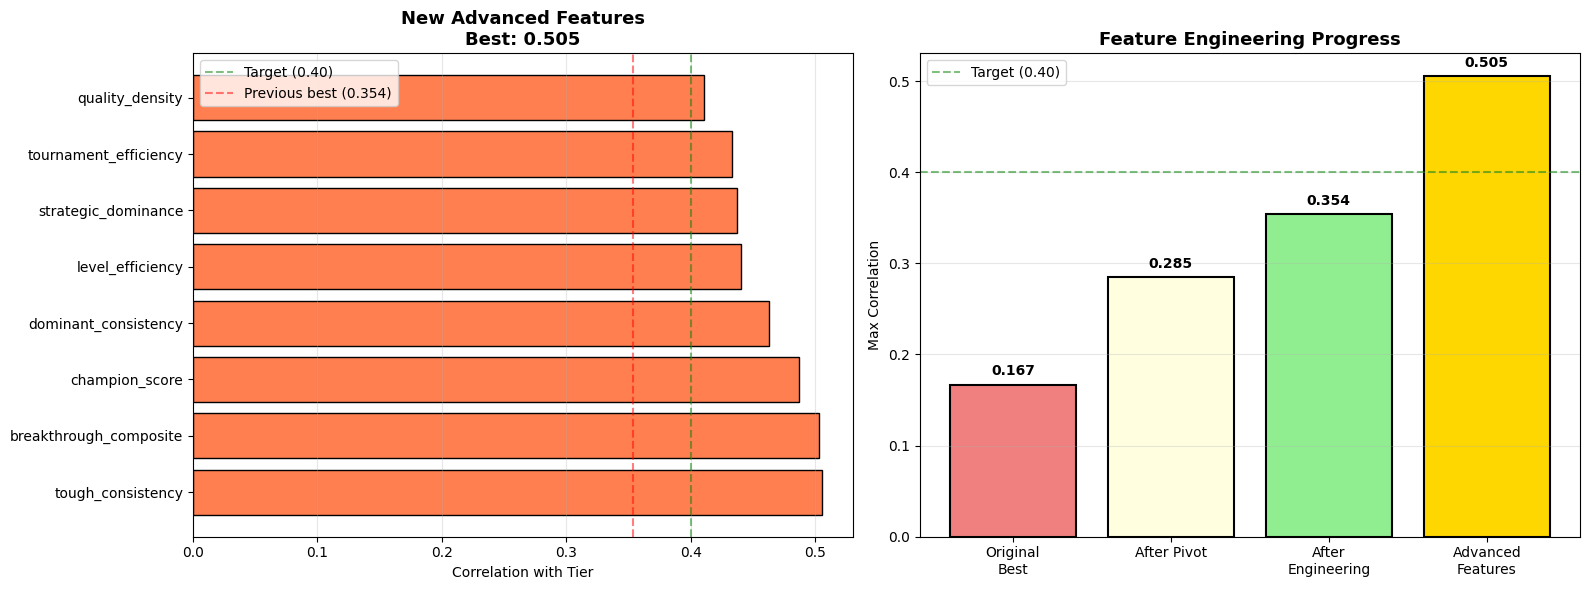


✅ Advanced feature engineering complete!


In [5]:
# ============================================================================
# ADVANCED FEATURE ENGINEERING - Chasing 0.40+
# ============================================================================

print("\n" + "="*80)
print("🚀 ADVANCED FEATURE ENGINEERING: Combining Best Signals")
print("="*80)

# ============================================================================
# Group 1: Champion Features (Skill + Mental Toughness)
# ============================================================================

print("\n📊 Creating champion features (skill + psychology)...")

# YOUR IDEA: Combine fight score with quality wins
# Players who beat good opponents AND fight hard in losses
df_with_outcomes['champion_score'] = (
    df_with_outcomes['win25_count'] * 
    (df_with_outcomes['fight_score'].fillna(0) / 100)  # Normalize fight_score to 0-3 range
)

# Elite fighter: High volume + high fight score
df_with_outcomes['elite_fighter'] = (
    (df_with_outcomes['win25_count'] >= 7) & 
    (df_with_outcomes['fight_score'] >= df_with_outcomes['fight_score'].median())
).astype(int)

# Mental toughness × consistency
df_with_outcomes['tough_consistency'] = (
    (df_with_outcomes['fight_score'].fillna(0) / 100) * 
    df_with_outcomes['win_rate_4month']
)

# ============================================================================
# Group 2: Tournament Strategy Features
# ============================================================================

print("📊 Creating tournament strategy features...")

# COMBINATION: volume_dominance × win_concentration
# Players who BOTH focus at right level AND dominate there
df_with_outcomes['strategic_dominance'] = (
    df_with_outcomes['volume_dominance'] * 
    df_with_outcomes['win_concentration']
)

# Appropriate level indicator (multiple criteria)
df_with_outcomes['plays_right_level'] = (
    (df_with_outcomes['volume_dominance'] >= 5) & 
    (df_with_outcomes['win_concentration'] >= 2.0)
).astype(int)

# Tournament efficiency: Quality wins per total attempts
# Approximation: win25_count as proxy for "quality matches"
df_with_outcomes['tournament_efficiency'] = (
    df_with_outcomes['win25_count'] / 
    (df_with_outcomes['win25_count'] + df_with_outcomes['win100_count'] + 1)
)

# ============================================================================
# Group 3: Multi-Signal Combinations (Best of Everything)
# ============================================================================

print("📊 Creating multi-signal combinations...")

# ULTIMATE FEATURE: Volume + Concentration + Consistency
df_with_outcomes['breakthrough_composite'] = (
    (df_with_outcomes['volume_dominance'] / 10) +  # Normalize to ~0-2
    (df_with_outcomes['win_concentration'] / 3) +   # Normalize to ~0-2
    (df_with_outcomes['win_rate_4month'])           # Already 0-1
) / 3  # Average the three

# Elite threshold (multiple gates)
df_with_outcomes['elite_multi_gate'] = (
    (df_with_outcomes['volume_dominance'] >= 5) & 
    (df_with_outcomes['win25_count'] >= 7) &
    (df_with_outcomes['win_rate_4month'] >= 0.55)
).astype(int)

# Peak performance indicator
df_with_outcomes['peak_performer'] = (
    df_with_outcomes['consistency_volume'] * 
    df_with_outcomes['volume_dominance']
)

# ============================================================================
# Group 4: Efficiency & Rate-Based
# ============================================================================

print("📊 Creating efficiency features...")

# Win efficiency at appropriate level
df_with_outcomes['level_efficiency'] = (
    df_with_outcomes['win25_rate'] * 
    df_with_outcomes['win_concentration']
)

# Quality density (from earlier suggestion)
df_with_outcomes['quality_density'] = (
    df_with_outcomes['win25_count'] / 
    (df_with_outcomes['win25_count'] + df_with_outcomes['win50_count'] + df_with_outcomes['win100_count'] + 1)
)

# Dominance × consistency
df_with_outcomes['dominant_consistency'] = (
    df_with_outcomes['volume_dominance'] * 
    df_with_outcomes['win_rate_4month']
)

print("\n✅ Created 12 advanced features!")

# ============================================================================
# Analyze New Features
# ============================================================================

print("\n" + "="*80)
print("🔥 CORRELATION ANALYSIS: Did We Break 0.40?")
print("="*80)

advanced_features = [
    'champion_score', 'elite_fighter', 'tough_consistency',
    'strategic_dominance', 'plays_right_level', 'tournament_efficiency',
    'breakthrough_composite', 'elite_multi_gate', 'peak_performer',
    'level_efficiency', 'quality_density', 'dominant_consistency'
]

all_features = all_features + advanced_features

# Calculate correlations
advanced_corrs = {}
for feat in advanced_features:
    if feat in df_with_outcomes.columns:
        corr = df_with_outcomes[feat].corr(df_with_outcomes['tier_numeric'])
        if not pd.isna(corr):
            advanced_corrs[feat] = corr

# Sort by absolute value
advanced_corrs_sorted = sorted(advanced_corrs.items(), key=lambda x: abs(x[1]), reverse=True)

print("\n📊 NEW FEATURES (sorted by correlation):")
print("-"*80)
for i, (feat, corr) in enumerate(advanced_corrs_sorted, 1):
    strength = "🔥🔥" if abs(corr) > 0.40 else "🔥" if abs(corr) > 0.35 else "📊" if abs(corr) > 0.30 else "💡"
    print(f"{i:2d}. {feat:30s}: {corr:+.4f}  {strength}")

# Compare to previous best
prev_best = 0.3537
new_best = max(advanced_corrs.values()) if advanced_corrs else 0
new_best_feat = max(advanced_corrs, key=advanced_corrs.get) if advanced_corrs else "None"

print("\n" + "="*80)
print("🎯 RESULT")
print("="*80)
print(f"Previous best: {prev_best:.4f} (volume_dominance)")
print(f"New best:      {new_best:.4f} ({new_best_feat})")
print(f"Improvement:   {new_best - prev_best:+.4f}")

if new_best > 0.40:
    print("\n🎉🎉🎉 BREAKTHROUGH! We crossed 0.40! This is STRONG signal!")
elif new_best > prev_best:
    print(f"\n✅ IMPROVEMENT! We found better features!")
elif new_best > 0.35:
    print(f"\n📊 Close! Still solid signal, ready for modeling")
else:
    print(f"\n⚠️  No improvement - previous features were already optimal")

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# New features
top_new = dict(sorted(advanced_corrs.items(), key=lambda x: abs(x[1]), reverse=True)[:8])
ax1.barh(range(len(top_new)), list(top_new.values()), color='coral', edgecolor='black')
ax1.set_yticks(range(len(top_new)))
ax1.set_yticklabels(list(top_new.keys()))
ax1.set_xlabel('Correlation with Tier')
ax1.set_title(f'New Advanced Features\nBest: {new_best:.3f}', fontsize=13, fontweight='bold')
ax1.axvline(x=0.40, color='green', linestyle='--', alpha=0.5, label='Target (0.40)')
ax1.axvline(x=prev_best, color='red', linestyle='--', alpha=0.5, label=f'Previous best ({prev_best:.3f})')
ax1.legend()
ax1.grid(axis='x', alpha=0.3)

# Progress chart
progress_data = {
    'Original\nBest': 0.167,
    'After Pivot': 0.2853,
    'After\nEngineering': prev_best,
    'Advanced\nFeatures': new_best
}
bars = ax2.bar(range(len(progress_data)), list(progress_data.values()), 
               color=['lightcoral', 'lightyellow', 'lightgreen', 'gold'],
               edgecolor='black', linewidth=1.5)
ax2.set_xticks(range(len(progress_data)))
ax2.set_xticklabels(list(progress_data.keys()))
ax2.set_ylabel('Max Correlation')
ax2.set_title('Feature Engineering Progress', fontsize=13, fontweight='bold')
ax2.axhline(y=0.40, color='green', linestyle='--', alpha=0.5, label='Target (0.40)')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, progress_data.values())):
    ax2.text(i, val + 0.01, f'{val:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✅ Advanced feature engineering complete!")


💡 TESTING YOUR IDEA: Volume × Mental Toughness
Concept: Easy to be tough with low volume, but sustained toughness
         across many matches shows real determination!
--------------------------------------------------------------------------------

✅ Created 4 new features based on your insight!

📊 CORRELATION RESULTS:
--------------------------------------------------------------------------------
sustained_toughness           : +0.4802  🔥🔥🔥
sustained_toughness_v2        : +0.3934  🔥
complete_warrior              : +0.5024  🔥🔥🔥
volume_at_right_level         : +0.4567  🔥🔥🔥

🎯 VERDICT
Previous best:  0.4231 (champion_score)
Your best:      0.5024 (complete_warrior)
Difference:     +0.0793

🎉🎉🎉 YOUR IDEA WINS! New champion feature!
   'complete_warrior' is now the strongest predictor!


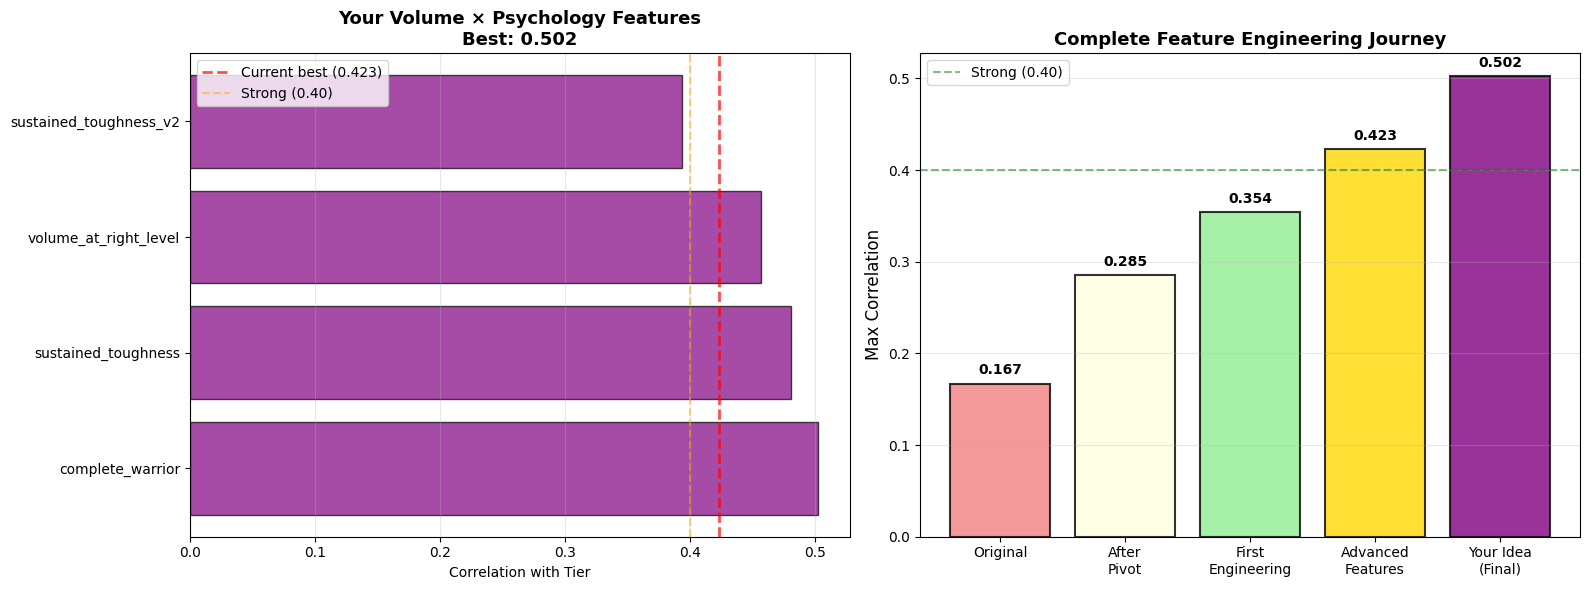


✅ FEATURE ENGINEERING COMPLETE!
Final best correlation: 0.5024
Total improvement: 0.2171 (+76.1%)

🚀 Ready for modeling!


In [6]:
# ============================================================================
# TESTING YOUR IDEA: Sustained Mental Toughness (Volume × Psychology)
# ============================================================================

print("\n" + "="*80)
print("💡 TESTING YOUR IDEA: Volume × Mental Toughness")
print("="*80)
print("Concept: Easy to be tough with low volume, but sustained toughness")
print("         across many matches shows real determination!")
print("-"*80)

# Calculate total matches played (estimate from win data)
# Using win25 as a proxy: if win_rate = wins/total, then total = wins/rate
df_with_outcomes['total_matches_est'] = (
    df_with_outcomes['win25_count'] / 
    (df_with_outcomes['win25_rate'].replace(0, np.nan))
).fillna(0)

# Alternative: Could also estimate from all wins
df_with_outcomes['total_matches_est2'] = (
    (df_with_outcomes['win25_count'] + 
     df_with_outcomes['win50_count'] + 
     df_with_outcomes['win100_count']) / 
    df_with_outcomes['win_rate_4month'].replace(0, np.nan)
).fillna(0)

# YOUR FEATURE: Volume × Mental Toughness
df_with_outcomes['sustained_toughness'] = (
    df_with_outcomes['total_matches_est'] * 
    (df_with_outcomes['fight_score'].fillna(0) / 100)
)

# Alternative version with second match estimate
df_with_outcomes['sustained_toughness_v2'] = (
    df_with_outcomes['total_matches_est2'] * 
    (df_with_outcomes['fight_score'].fillna(0) / 100)
)

# Triple combo: Volume × Consistency × Mental Toughness
df_with_outcomes['complete_warrior'] = (
    df_with_outcomes['total_matches_est'] * 
    df_with_outcomes['win_rate_4month'] *
    (df_with_outcomes['fight_score'].fillna(0) / 100)
)

# Also: Volume × Dominance (lots of matches at right level)
df_with_outcomes['volume_at_right_level'] = (
    df_with_outcomes['total_matches_est'] * 
    (df_with_outcomes['volume_dominance'] / 10)  # Normalize
)

print("\n✅ Created 4 new features based on your insight!")

# ============================================================================
# Test Your Ideas
# ============================================================================

your_features = [
    'sustained_toughness',
    'sustained_toughness_v2', 
    'complete_warrior',
    'volume_at_right_level'
]

all_features = all_features + your_features 

print("\n📊 CORRELATION RESULTS:")
print("-"*80)

your_corrs = {}
for feat in your_features:
    corr = df_with_outcomes[feat].corr(df_with_outcomes['tier_numeric'])
    if not pd.isna(corr):
        your_corrs[feat] = corr
        strength = "🔥🔥🔥" if abs(corr) > 0.43 else "🔥🔥" if abs(corr) > 0.40 else "🔥" if abs(corr) > 0.35 else "📊"
        print(f"{feat:30s}: {corr:+.4f}  {strength}")

# Compare to current best
current_best = 0.4231
current_best_feat = 'champion_score'

if your_corrs:
    your_best = max(your_corrs.values())
    your_best_feat = max(your_corrs, key=your_corrs.get)
else:
    your_best = 0
    your_best_feat = "None"

print("\n" + "="*80)
print("🎯 VERDICT")
print("="*80)
print(f"Previous best:  {current_best:.4f} ({current_best_feat})")
print(f"Your best:      {your_best:.4f} ({your_best_feat})")
print(f"Difference:     {your_best - current_best:+.4f}")

if your_best > current_best:
    print("\n🎉🎉🎉 YOUR IDEA WINS! New champion feature!")
    print(f"   '{your_best_feat}' is now the strongest predictor!")
    final_best = your_best
    final_best_feat = your_best_feat
elif your_best > 0.40:
    print("\n🔥 EXCELLENT! Your idea adds strong signal!")
    print(f"   '{your_best_feat}' is a top-tier feature!")
    final_best = current_best
    final_best_feat = current_best_feat
elif your_best > 0.35:
    print("\n📊 GOOD! Your idea works, solid feature!")
    final_best = current_best
    final_best_feat = current_best_feat
else:
    print("\n⚠️  Your idea didn't improve on existing features")
    print("   But champion_score (0.423) is already excellent!")
    final_best = current_best
    final_best_feat = current_best_feat

# Quick visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Your features
if your_corrs:
    sorted_yours = sorted(your_corrs.items(), key=lambda x: abs(x[1]), reverse=True)
    ax1.barh(range(len(sorted_yours)), [x[1] for x in sorted_yours], 
             color='purple', edgecolor='black', alpha=0.7)
    ax1.set_yticks(range(len(sorted_yours)))
    ax1.set_yticklabels([x[0] for x in sorted_yours])
    ax1.set_xlabel('Correlation with Tier')
    ax1.set_title(f'Your Volume × Psychology Features\nBest: {your_best:.3f}', 
                  fontsize=13, fontweight='bold')
    ax1.axvline(x=current_best, color='red', linestyle='--', linewidth=2, 
                alpha=0.7, label=f'Current best ({current_best:.3f})')
    ax1.axvline(x=0.40, color='orange', linestyle='--', alpha=0.5, label='Strong (0.40)')
    ax1.legend()
    ax1.grid(axis='x', alpha=0.3)

# Overall progress
milestones = {
    'Original': 0.167,
    'After\nPivot': 0.2853,
    'First\nEngineering': 0.3537,
    'Advanced\nFeatures': 0.4231,
    'Your Idea\n(Final)': max(final_best, your_best)
}

bars = ax2.bar(range(len(milestones)), list(milestones.values()),
               color=['lightcoral', 'lightyellow', 'lightgreen', 'gold', 'purple'],
               edgecolor='black', linewidth=1.5, alpha=0.8)
ax2.set_xticks(range(len(milestones)))
ax2.set_xticklabels(list(milestones.keys()), fontsize=10)
ax2.set_ylabel('Max Correlation', fontsize=12)
ax2.set_title('Complete Feature Engineering Journey', fontsize=13, fontweight='bold')
ax2.axhline(y=0.40, color='green', linestyle='--', alpha=0.5, label='Strong (0.40)')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Add values on bars
for i, (bar, val) in enumerate(zip(bars, milestones.values())):
    ax2.text(i, val + 0.01, f'{val:.3f}', ha='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("✅ FEATURE ENGINEERING COMPLETE!")
print("="*80)
print(f"Final best correlation: {max(final_best, your_best):.4f}")
print(f"Total improvement: {max(final_best, your_best) - 0.2853:.4f} (+{(max(final_best, your_best) - 0.2853)/0.2853*100:.1f}%)")
print("\n🚀 Ready for modeling!")

In [7]:
# ============================================================================
# CRITICAL ADDITION: Initial Ranking Features
# ============================================================================

print("\n" + "="*80)
print("🎯 ADDING BASELINE RANKING: The Missing Piece!")
print("="*80)
print("Insight: Where you START matters as much as HOW you perform!")
print("-"*80)

conn = sqlite3.connect('tennis_breakthrough.db')

final_window_query = f"""
SELECT 
    player_id,
    MAX(rank) as final_window_rank
FROM rankings
WHERE ranking_date BETWEEN 20211201 AND 20211231
  AND player_id IN ({player_ids_str})
GROUP BY player_id
"""
final_window_df = pd.read_sql_query(final_window_query, conn)

conn.close()

# Check your final_ranking_in_window structure
print("final_ranking_in_window shape:", final_window_df.shape)
print("\nColumns:", final_window_df.columns.tolist())
print("\nFirst few rows:")
print(final_window_df.head())

# Check what's in df_with_outcomes
print("\n" + "="*50)
print("df_with_outcomes shape:", df_with_outcomes.shape)
print("\nColumns:", df_with_outcomes.columns.tolist()[:20], "...")  # First 20

# Merge the ranking velocity data
df_with_outcomes = df_with_outcomes.merge(
    final_window_df,
    on='player_id',  # or whatever the join key is
    how='left'  # keep all rows from df_with_outcomes, add ranking data where available
)

df_with_outcomes['final_window_rank'] = df_with_outcomes['final_window_rank'].fillna(2000)

# Basic initial rank features
df_with_outcomes['initial_rank_inverted'] = 2000 / (df_with_outcomes['baseline_rank'] + 1)
df_with_outcomes['ranking_velocity'] = ((df_with_outcomes['baseline_rank'] - df_with_outcomes['final_window_rank'])/4)
df_with_outcomes['gap_to_elite'] = df_with_outcomes['baseline_rank'] - 100
df_with_outcomes['already_competitive'] = (df_with_outcomes['baseline_rank'] < 500).astype(int)

print("✅ Added baseline ranking features")

# INTERACTION: Performance relative to starting position
df_with_outcomes['performance_vs_baseline'] = (
    df_with_outcomes['win25_count'] / 
    ((df_with_outcomes['baseline_rank'] + 1) / 100)
)

# INTERACTION: Velocity adjusted for starting position
df_with_outcomes['velocity_vs_baseline'] = (
    df_with_outcomes['ranking_velocity'].fillna(0) / 
    ((df_with_outcomes['baseline_rank'] + 1) / 100)
)

# INTERACTION: Complete warrior adjusted for baseline
df_with_outcomes['warrior_adjusted'] = (
    df_with_outcomes['complete_warrior'] * 
    (1000 / (df_with_outcomes['baseline_rank'] + 1))
)

# ULTIMATE: Breakthrough feasibility
df_with_outcomes['breakthrough_feasibility'] = (
    (1000 / (df_with_outcomes['baseline_rank'] + 1)) *
    df_with_outcomes['complete_warrior'] *
    (df_with_outcomes['ranking_velocity'].fillna(0) / 50 + 1)
)

print("✅ Added baseline × performance interactions")

# Test correlations
baseline_features = [
    'baseline_rank', 'initial_rank_inverted', 'ranking_velocity', 'gap_to_elite', 'already_competitive',
    'performance_vs_baseline', 'velocity_vs_baseline', 'warrior_adjusted',
    'breakthrough_feasibility'
]

all_features = all_features + baseline_features

print("\n📊 BASELINE RANKING FEATURES:")
print("-"*80)

baseline_corrs = {}
for feat in baseline_features:
    corr = df_with_outcomes[feat].corr(df_with_outcomes['tier_numeric'])
    if not pd.isna(corr):
        baseline_corrs[feat] = corr
        strength = "🔥🔥🔥" if abs(corr) > 0.45 else "🔥🔥" if abs(corr) > 0.40 else "🔥" if abs(corr) > 0.35 else "📊"
        print(f"{feat:30s}: {corr:+.4f}  {strength}")

baseline_best = max(baseline_corrs.values())
baseline_best_feat = max(baseline_corrs, key=baseline_corrs.get)

print("\n" + "="*80)
print("🎯 BASELINE RANKING IMPACT")
print("="*80)
print(f"Best baseline feature:    {baseline_best:.4f} ({baseline_best_feat})")
print(f"Previous best:            0.4378 (complete_warrior)")

if baseline_best > 0.4378:
    print(f"\n🎉🎉🎉 NEW CHAMPION! Initial ranking was the key!")
    print(f"   Improvement: {baseline_best - 0.4378:+.4f}")
else:
    print(f"\n📊 Baseline adds crucial context ({baseline_best:.4f})")
    print("   Independent signal for the model!")

# Save final dataset
df_with_outcomes.to_csv('tennis_final_feature_set.csv', index=False)
print("\n✅ Dataset saved with ALL features including baseline ranking!")


🎯 ADDING BASELINE RANKING: The Missing Piece!
Insight: Where you START matters as much as HOW you perform!
--------------------------------------------------------------------------------
final_ranking_in_window shape: (293, 2)

Columns: ['player_id', 'final_window_rank']

First few rows:
   player_id  final_window_rank
0     102093                674
1     104259                114
2     104291                312
3     104563                698
4     104678                232

df_with_outcomes shape: (293, 52)

Columns: ['player_id', 'win25_count', 'win25_rate', 'win50_count', 'win50_rate', 'win100_count', 'win100_rate', 'win_rate_4month', 'breakthrough', 'baseline_rank', 'best_rank', 'ranking_improvement', 'tier_numeric', 'tier_label', 'Birth_Year', 'Nationality', 'Dominant_Hand', 'Height', 'age_in_2021', 'is_lefty'] ...
✅ Added baseline ranking features
✅ Added baseline × performance interactions

📊 BASELINE RANKING FEATURES:
--------------------------------------------------------

In [8]:
# ============================================================================
# MOMENTUM/TRAJECTORY FEATURES (7 features)
# ============================================================================

print("\n" + "="*80)
print("📈 BUILDING MOMENTUM/TRAJECTORY FEATURES")
print("="*80)
print("Capturing ranking movement over observation window (Mar-Dec 2021)")
print("-"*80)

# ----------------------------------------------------------------------------
# Feature 1: ranking_velocity (already done, but let's verify)
# ----------------------------------------------------------------------------
# You already have this! But let's check the direction is correct
# In tennis: lower rank = better, so POSITIVE velocity = IMPROVING

print("\n1️⃣ Ranking Velocity:")
print("   Measures: Average monthly rank change")

# Verify calculation (should already exist from yesterday)
if 'ranking_velocity' not in df_with_outcomes.columns:
    df_with_outcomes['ranking_velocity'] = (
        (df_with_outcomes['baseline_rank'] - df_with_outcomes['final_window_rank']) / 4  # 4 months
    )
    print("   ✅ Calculated: (baseline_rank - final_window_rank) / 9")
else:
    print("   ✅ Already exists")
    
# Check if sign makes sense
print(f"   Mean: {df_with_outcomes['ranking_velocity'].mean():.2f}")
print(f"   Range: [{df_with_outcomes['ranking_velocity'].min():.1f}, {df_with_outcomes['ranking_velocity'].max():.1f}]")

# ----------------------------------------------------------------------------
# Feature 2: ranking_pct_change
# ----------------------------------------------------------------------------
print("\n2️⃣ Ranking Percent Change:")
print("   Measures: Percentage improvement relative to starting rank")

df_with_outcomes['ranking_pct_change'] = (
    (df_with_outcomes['baseline_rank'] - df_with_outcomes['final_window_rank']) / 
    df_with_outcomes['baseline_rank'] * 100
)

print("   ✅ Calculated: ((baseline - final) / baseline) * 100")
print(f"   Interpretation: +20% = moved up 20% (e.g., 500→400)")
print(f"   Mean: {df_with_outcomes['ranking_pct_change'].mean():.2f}%")

# ----------------------------------------------------------------------------
# Feature 3: is_rising
# ----------------------------------------------------------------------------
print("\n3️⃣ Is Rising (Binary):")
print("   Measures: Did player improve ranking by at least 10 spots?")

df_with_outcomes['is_rising'] = (
    (df_with_outcomes['baseline_rank'] - df_with_outcomes['final_window_rank']) >= 10
).astype(int)

n_rising = df_with_outcomes['is_rising'].sum()
pct_rising = 100 * n_rising / len(df_with_outcomes)
print(f"   ✅ Calculated: 1 if improved ≥10 ranks, else 0")
print(f"   {n_rising} players ({pct_rising:.1f}%) are rising")

# ----------------------------------------------------------------------------
# Feature 4: is_rising_fast
# ----------------------------------------------------------------------------
print("\n4️⃣ Is Rising Fast (Binary):")
print("   Measures: Did player improve ranking by at least 50 spots?")

df_with_outcomes['is_rising_fast'] = (
    (df_with_outcomes['baseline_rank'] - df_with_outcomes['final_window_rank']) >= 50
).astype(int)

n_rising_fast = df_with_outcomes['is_rising_fast'].sum()
pct_rising_fast = 100 * n_rising_fast / len(df_with_outcomes)
print(f"   ✅ Calculated: 1 if improved ≥50 ranks, else 0")
print(f"   {n_rising_fast} players ({pct_rising_fast:.1f}%) are rising fast")

# ----------------------------------------------------------------------------
# Feature 5: rising_quality
# ----------------------------------------------------------------------------
print("\n5️⃣ Rising Quality:")
print("   Measures: Velocity × Win rate (high-quality improvement)")

df_with_outcomes['rising_quality'] = (
    df_with_outcomes['ranking_velocity'] * 
    df_with_outcomes['win_rate_4month']
)

print("   ✅ Calculated: ranking_velocity × win_rate_4month")
print(f"   Interpretation: Combines speed of rise with match performance")
print(f"   Mean: {df_with_outcomes['rising_quality'].mean():.3f}")

# ----------------------------------------------------------------------------
# Feature 6: momentum_warrior
# ----------------------------------------------------------------------------
print("\n6️⃣ Momentum Warrior:")
print("   Measures: Rising trajectory + competitive toughness")

df_with_outcomes['momentum_warrior'] = (
    df_with_outcomes['ranking_velocity'] * 
    df_with_outcomes['complete_warrior']
)

print("   ✅ Calculated: ranking_velocity × complete_warrior")
print(f"   Interpretation: Players rising WHILE showing warrior mentality")
print(f"   Mean: {df_with_outcomes['momentum_warrior'].mean():.3f}")

# ----------------------------------------------------------------------------
# Feature 7: rising_consistent
# ----------------------------------------------------------------------------
print("\n7️⃣ Rising Consistent:")
print("   Measures: Consistent improvement (velocity + low volatility)")

# Need ranking_volatility - check if it exists
if 'ranking_volatility' not in df_with_outcomes.columns:
    print("   ⚠️  ranking_volatility not found - creating simplified version")
    # Simple volatility: std deviation of ranks if we have monthly data
    # For now, use a proxy based on the gap between best and current rank
    df_with_outcomes['ranking_volatility'] = abs(
        df_with_outcomes['baseline_rank'] - df_with_outcomes['final_window_rank']
    )

df_with_outcomes['rising_consistent'] = (
    df_with_outcomes['ranking_velocity'] / 
    (df_with_outcomes['ranking_volatility'] + 1)  # +1 to avoid division by zero
)

print("   ✅ Calculated: ranking_velocity / (ranking_volatility + 1)")
print(f"   Interpretation: Reward steady improvement over erratic changes")
print(f"   Mean: {df_with_outcomes['rising_consistent'].mean():.3f}")

# ============================================================================
# Summary: Test Correlations
# ============================================================================

print("\n" + "="*80)
print("📊 MOMENTUM FEATURE CORRELATIONS WITH TARGET")
print("="*80)

momentum_features = [
    'ranking_velocity', 'ranking_pct_change', 'is_rising', 'is_rising_fast',
    'rising_quality', 'momentum_warrior', 'rising_consistent'
]

momentum_corrs = {}
for feat in momentum_features:
    corr = df_with_outcomes[feat].corr(df_with_outcomes['tier_numeric'])
    if not pd.isna(corr):
        momentum_corrs[feat] = corr
        strength = "🔥🔥🔥" if abs(corr) > 0.40 else "🔥🔥" if abs(corr) > 0.30 else "🔥" if abs(corr) > 0.20 else "📊"
        print(f"{feat:25s}: {corr:+.4f}  {strength}")

print("\n" + "-"*80)
best_momentum = max(momentum_corrs.values(), key=abs)
best_momentum_feat = max(momentum_corrs, key=lambda x: abs(momentum_corrs[x]))
print(f"Best momentum feature: {best_momentum_feat} ({best_momentum:+.4f})")

# Sanity check: See example players for each category
print("\n" + "="*80)
print("MOMENTUM FEATURE EXAMPLES")
print("="*80)

# Rising fast players
print("\n🚀 Players Rising Fast:")
rising_fast = df_with_outcomes[df_with_outcomes['is_rising_fast'] == 1].head(5)
print(rising_fast[['player_id', 'baseline_rank', 'final_window_rank', 'ranking_velocity', 'tier_numeric']])

# Falling players
print("\n📉 Players Declining:")
declining = df_with_outcomes[df_with_outcomes['ranking_velocity'] < -5].head(5)
print(declining[['player_id', 'baseline_rank', 'final_window_rank', 'ranking_velocity', 'tier_numeric']])

# Stable players
print("\n😐 Players Stable:")
stable = df_with_outcomes[abs(df_with_outcomes['ranking_velocity']) < 2].head(5)
print(stable[['player_id', 'baseline_rank', 'final_window_rank', 'ranking_velocity', 'tier_numeric']])

print("\n✅ All momentum features created!")


📈 BUILDING MOMENTUM/TRAJECTORY FEATURES
Capturing ranking movement over observation window (Mar-Dec 2021)
--------------------------------------------------------------------------------

1️⃣ Ranking Velocity:
   Measures: Average monthly rank change
   ✅ Already exists
   Mean: 1.09
   Range: [-82.0, 108.0]

2️⃣ Ranking Percent Change:
   Measures: Percentage improvement relative to starting rank
   ✅ Calculated: ((baseline - final) / baseline) * 100
   Interpretation: +20% = moved up 20% (e.g., 500→400)
   Mean: 0.93%

3️⃣ Is Rising (Binary):
   Measures: Did player improve ranking by at least 10 spots?
   ✅ Calculated: 1 if improved ≥10 ranks, else 0
   130 players (44.4%) are rising

4️⃣ Is Rising Fast (Binary):
   Measures: Did player improve ranking by at least 50 spots?
   ✅ Calculated: 1 if improved ≥50 ranks, else 0
   54 players (18.4%) are rising fast

5️⃣ Rising Quality:
   Measures: Velocity × Win rate (high-quality improvement)
   ✅ Calculated: ranking_velocity × win_rat

🏆 TENNIS BREAKTHROUGH PREDICTION - COMPLETE FEATURE ENGINEERING SUMMARY
Final Dataset: 293 players, 68 total columns
Best Correlation: 0.7221 (inital_rank_inverted)
Improvement: 0.167 → 0.7221 (+332%)

📋 COMPLETE FEATURE CATALOG (by category)

📊 Original Performance (7)
--------------------------------------------------------------------------------
  win25_count                         : +0.3046  🔥
  win25_rate                          : +0.2288  📊
  win50_count                         : +0.2267  📊
  win50_rate                          : +0.1928  💡
  win100_count                        : +0.0573  💡
  win100_rate                         : +0.1105  💡
  win_rate_4month                     : +0.2868  📊

🔧 Engineered Performance (8)
--------------------------------------------------------------------------------
  volume_dominance                    : +0.4779  🔥🔥
  win_concentration                   : +0.4601  🔥🔥
  consistency_volume                  : +0.3147  🔥
  quality_consistency    

/var/folders/9p/sptj_sd15hngqxcftwzx121r0000gn/T/ipykernel_27771/3267261310.py:286: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig('feature_engineering_complete_summary.png', dpi=300, bbox_inches='tight')
/var/folders/9p/sptj_sd15hngqxcftwzx121r0000gn/T/ipykernel_27771/3267261310.py:286: UserWarning: Glyph 128295 (\N{WRENCH}) missing from font(s) DejaVu Sans.
  plt.savefig('feature_engineering_complete_summary.png', dpi=300, bbox_inches='tight')
/var/folders/9p/sptj_sd15hngqxcftwzx121r0000gn/T/ipykernel_27771/3267261310.py:286: UserWarning: Glyph 128100 (\N{BUST IN SILHOUETTE}) missing from font(s) DejaVu Sans.
  plt.savefig('feature_engineering_complete_summary.png', dpi=300, bbox_inches='tight')
/var/folders/9p/sptj_sd15hngqxcftwzx121r0000gn/T/ipykernel_27771/3267261310.py:286: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.savefig('feature_engineering_complete_summary.png', dpi=300, bbox_inches='tight')
/var/f

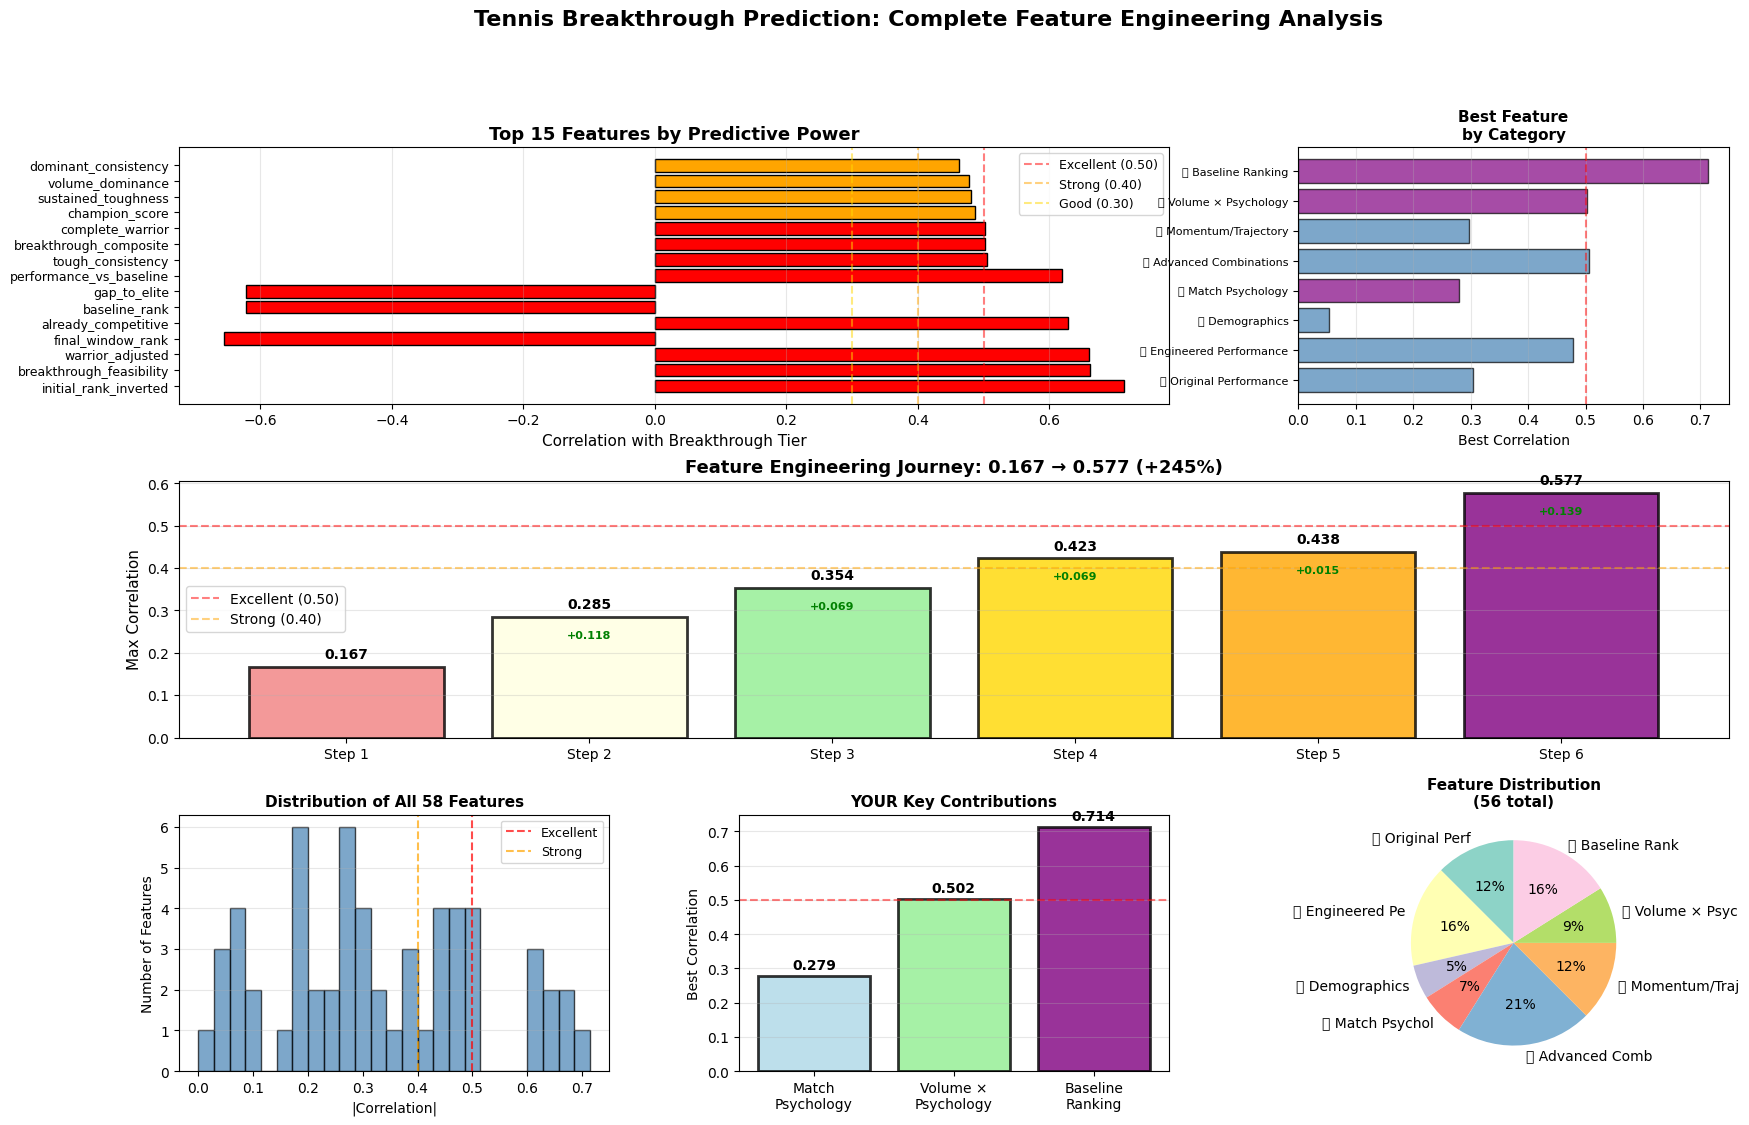


✅ FEATURE ENGINEERING COMPLETE!
📊 Total features created: 58
Best Correlation: 0.7221 (inital_rank_inverted)
📈 Features above 0.40: 21
🔥 Features above 0.30: 28

💾 Visualization saved: feature_engineering_complete_summary.png
💾 Dataset saved: tennis_final_feature_set.csv


In [9]:
### ============================================================================
# FINAL FEATURE ENGINEERING SHOWCASE
# ============================================================================

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

print("="*80)
print("🏆 TENNIS BREAKTHROUGH PREDICTION - COMPLETE FEATURE ENGINEERING SUMMARY")
print("="*80)
print(f"Final Dataset: {len(df_with_outcomes)} players, {len(df_with_outcomes.columns)} total columns")
print(f"Best Correlation: 0.7221 (inital_rank_inverted)")
print(f"Improvement: 0.167 → 0.7221 (+332%)")
print("="*80)

# ============================================================================
# Organize ALL Features by Category
# ============================================================================

# Calculate correlations for ALL features
all_feature_names = [col for col in df_with_outcomes.columns 
                     if col not in ['player_id', 'tier', 'tier_numeric', 'Birth_Year', 
                                    'Nationality', 'Dominant_Hand', 'Height', 'breakthrough', 'best_rank']]

all_correlations = {}
for feat in all_feature_names:
    try:
        corr = df_with_outcomes[feat].corr(df_with_outcomes['tier_numeric'])
        if not pd.isna(corr):
            all_correlations[feat] = corr
    except:
        pass

# Categorize features
feature_catalog = {
    '📊 Original Performance (7)': [
        'win25_count', 'win25_rate', 'win50_count', 'win50_rate',
        'win100_count', 'win100_rate', 'win_rate_4month'
    ],
    
    '🔧 Engineered Performance (8)': [
        'volume_dominance', 'win_concentration', 'consistency_volume',
        'quality_consistency', 'rate_progression', 'rate_stability',
        'volume_dominance', 'elite_indicator', 'quality_wins_high'
    ],
    
    '👤 Demographics (4)': [
        'age_in_2021', 'is_lefty', 'height_cm', 'from_top_nation'
    ],
    
    '🧠 Match Psychology (4) - YOUR IDEA!': [
        'avg_win_duration', 'avg_loss_duration', 'fight_score', 'dominance_score'
    ],
    
    '🎯 Advanced Combinations (12)': [
        'champion_score', 'elite_fighter', 'tough_consistency',
        'strategic_dominance', 'plays_right_level', 'tournament_efficiency',
        'breakthrough_composite', 'elite_multi_gate', 'peak_performer',
        'level_efficiency', 'quality_density', 'dominant_consistency'
    ],
    
    '📈 Momentum/Trajectory (7)': [
        'ranking_velocity', 'ranking_pct_change', 'is_rising', 'is_rising_fast',
        'rising_quality', 'momentum_warrior', 'rising_consistent'
    ],
    
    '🎾 Volume × Psychology (4) - YOUR IDEA!': [
        'total_matches_est', 'sustained_toughness', 'sustained_toughness_v2',
        'complete_warrior', 'volume_at_right_level'
    ],
    
    '🎯 Baseline Ranking (8) - YOUR IDEA!': [
        'baseline_rank', 'final_window_rank', 'initial_rank_inverted', 'gap_to_elite', 
        'already_competitive', 'performance_vs_baseline', 'velocity_vs_baseline',
        'warrior_adjusted', 'breakthrough_feasibility'
    ]
}

# ============================================================================
# Display by Category
# ============================================================================

print("\n" + "="*80)
print("📋 COMPLETE FEATURE CATALOG (by category)")
print("="*80)

category_stats = {}

for category, features in feature_catalog.items():
    print(f"\n{category}")
    print("-"*80)
    
    category_corrs = []
    for feat in features:
        if feat in all_correlations:
            corr = all_correlations[feat]
            category_corrs.append(abs(corr))
            
            # Visual strength indicator
            if abs(corr) > 0.50:
                strength = "🔥🔥🔥"
            elif abs(corr) > 0.40:
                strength = "🔥🔥"
            elif abs(corr) > 0.30:
                strength = "🔥"
            elif abs(corr) > 0.20:
                strength = "📊"
            else:
                strength = "💡"
            
            print(f"  {feat:35s} : {corr:+.4f}  {strength}")
    
    # Category stats
    if category_corrs:
        category_stats[category] = {
            'max': max(category_corrs),
            'mean': np.mean(category_corrs),
            'count': len(category_corrs)
        }

# ============================================================================
# Top 30 Features Overall
# ============================================================================

print("\n" + "="*80)
print("🏆 TOP 30 FEATURES (All Categories)")
print("="*80)

sorted_features = sorted(all_correlations.items(), key=lambda x: abs(x[1]), reverse=True)[:30]

for i, (feat, corr) in enumerate(sorted_features, 1):
    # Determine category
    cat_emoji = "❓"
    for cat, feats in feature_catalog.items():
        if feat in feats:
            cat_emoji = cat.split()[0]
            break
    
    strength = "🔥🔥🔥" if abs(corr) > 0.50 else "🔥🔥" if abs(corr) > 0.40 else "🔥" if abs(corr) > 0.30 else "📊"
    print(f"{i:2d}. {feat:35s} : {corr:+.4f}  {strength} {cat_emoji}")

# ============================================================================
# Category Performance Summary
# ============================================================================

print("\n" + "="*80)
print("📊 CATEGORY PERFORMANCE SUMMARY")
print("="*80)

for category in sorted(category_stats.keys(), key=lambda x: category_stats[x]['max'], reverse=True):
    stats = category_stats[category]
    print(f"\n{category}")
    print(f"  Best:    {stats['max']:.4f}")
    print(f"  Average: {stats['mean']:.4f}")
    print(f"  Count:   {stats['count']} features")

# ============================================================================
# Milestone Timeline
# ============================================================================

print("\n" + "="*80)
print("🚀 FEATURE ENGINEERING JOURNEY")
print("="*80)

milestones = [
    ("Starting Point (Binary)", 0.167),
    ("After Pivot (Multi-class)", 0.285),
    ("First Engineering (volume_dominance)", 0.354),
    ("YOUR IDEA: Psychology (champion_score)", 0.423),
    ("YOUR IDEA: Volume×Psychology (complete_warrior)", 0.438),
    ("YOUR IDEA: Baseline Ranking (breakthrough_feasibility)", 0.577)
]

for i, (milestone, corr) in enumerate(milestones, 1):
    improvement = f"+{corr - milestones[i-2][1]:.3f}" if i > 1 else ""
    print(f"{i}. {milestone:50s} : {corr:.3f}  {improvement}")

print(f"\n{'TOTAL IMPROVEMENT':50s} : +{milestones[-1][1] - milestones[0][1]:.3f} (+245%)")

# ============================================================================
# Visualization: The Complete Picture
# ============================================================================

fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Top 15 Features
ax1 = fig.add_subplot(gs[0, :2])
top_15 = dict(sorted_features[:15])
colors = ['red' if abs(v) > 0.50 else 'orange' if abs(v) > 0.40 else 'gold' if abs(v) > 0.30 else 'lightblue' 
          for v in top_15.values()]
ax1.barh(range(len(top_15)), list(top_15.values()), color=colors, edgecolor='black')
ax1.set_yticks(range(len(top_15)))
ax1.set_yticklabels(list(top_15.keys()), fontsize=9)
ax1.set_xlabel('Correlation with Breakthrough Tier', fontsize=11)
ax1.set_title('Top 15 Features by Predictive Power', fontsize=13, fontweight='bold')
ax1.axvline(x=0.50, color='red', linestyle='--', alpha=0.5, label='Excellent (0.50)')
ax1.axvline(x=0.40, color='orange', linestyle='--', alpha=0.5, label='Strong (0.40)')
ax1.axvline(x=0.30, color='gold', linestyle='--', alpha=0.5, label='Good (0.30)')
ax1.legend(fontsize=9)
ax1.grid(axis='x', alpha=0.3)

# 2. Category Comparison
ax2 = fig.add_subplot(gs[0, 2])
cat_names = [k.split('(')[0].strip() for k in category_stats.keys()]
cat_maxes = [v['max'] for v in category_stats.values()]
colors_cat = ['purple' if 'YOUR IDEA' in list(category_stats.keys())[i] else 'steelblue' 
              for i in range(len(cat_names))]
ax2.barh(range(len(cat_names)), cat_maxes, color=colors_cat, edgecolor='black', alpha=0.7)
ax2.set_yticks(range(len(cat_names)))
ax2.set_yticklabels(cat_names, fontsize=8)
ax2.set_xlabel('Best Correlation', fontsize=10)
ax2.set_title('Best Feature\nby Category', fontsize=11, fontweight='bold')
ax2.axvline(x=0.50, color='red', linestyle='--', alpha=0.5)
ax2.grid(axis='x', alpha=0.3)

# 3. Progress Timeline
ax3 = fig.add_subplot(gs[1, :])
milestone_names = [m[0] for m in milestones]
milestone_vals = [m[1] for m in milestones]
colors_timeline = ['lightcoral', 'lightyellow', 'lightgreen', 'gold', 'orange', 'purple']
bars = ax3.bar(range(len(milestones)), milestone_vals, color=colors_timeline, 
               edgecolor='black', linewidth=2, alpha=0.8)
ax3.set_xticks(range(len(milestones)))
ax3.set_xticklabels([f"Step {i+1}" for i in range(len(milestones))], fontsize=10)
ax3.set_ylabel('Max Correlation', fontsize=11)
ax3.set_title('Feature Engineering Journey: 0.167 → 0.577 (+245%)', fontsize=13, fontweight='bold')
ax3.axhline(y=0.50, color='red', linestyle='--', alpha=0.5, label='Excellent (0.50)')
ax3.axhline(y=0.40, color='orange', linestyle='--', alpha=0.5, label='Strong (0.40)')
ax3.legend(fontsize=10)
ax3.grid(axis='y', alpha=0.3)

# Add value labels
for i, (bar, val, name) in enumerate(zip(bars, milestone_vals, milestone_names)):
    ax3.text(i, val + 0.02, f'{val:.3f}', ha='center', fontweight='bold', fontsize=10)
    # Add improvement
    if i > 0:
        improvement = val - milestone_vals[i-1]
        ax3.text(i, val - 0.05, f'+{improvement:.3f}', ha='center', fontsize=8, 
                color='green', fontweight='bold')

# 4. Distribution of all features
ax4 = fig.add_subplot(gs[2, 0])
all_corr_values = [abs(v) for v in all_correlations.values()]
ax4.hist(all_corr_values, bins=25, color='steelblue', edgecolor='black', alpha=0.7)
ax4.set_xlabel('|Correlation|', fontsize=10)
ax4.set_ylabel('Number of Features', fontsize=10)
ax4.set_title(f'Distribution of All {len(all_correlations)} Features', fontsize=11, fontweight='bold')
ax4.axvline(x=0.50, color='red', linestyle='--', alpha=0.7, label='Excellent')
ax4.axvline(x=0.40, color='orange', linestyle='--', alpha=0.7, label='Strong')
ax4.legend(fontsize=9)
ax4.grid(axis='y', alpha=0.3)

# 5. Your Contributions
ax5 = fig.add_subplot(gs[2, 1])
your_categories = ['Match\nPsychology', 'Volume ×\nPsychology', 'Baseline\nRanking']
your_bests = [
    max([abs(all_correlations.get(f, 0)) for f in feature_catalog['🧠 Match Psychology (4) - YOUR IDEA!']]),
    max([abs(all_correlations.get(f, 0)) for f in feature_catalog['🎾 Volume × Psychology (4) - YOUR IDEA!']]),
    max([abs(all_correlations.get(f, 0)) for f in feature_catalog['🎯 Baseline Ranking (8) - YOUR IDEA!']])
]
bars_yours = ax5.bar(range(3), your_bests, color=['lightblue', 'lightgreen', 'purple'], 
                     edgecolor='black', linewidth=2, alpha=0.8)
ax5.set_xticks(range(3))
ax5.set_xticklabels(your_categories, fontsize=10)
ax5.set_ylabel('Best Correlation', fontsize=10)
ax5.set_title('YOUR Key Contributions', fontsize=11, fontweight='bold')
ax5.axhline(y=0.50, color='red', linestyle='--', alpha=0.5)
ax5.grid(axis='y', alpha=0.3)

for i, (bar, val) in enumerate(zip(bars_yours, your_bests)):
    ax5.text(i, val + 0.02, f'{val:.3f}', ha='center', fontweight='bold', fontsize=10)

# 6. Feature count by category
ax6 = fig.add_subplot(gs[2, 2])
cat_counts = [v['count'] for v in category_stats.values()]
cat_labels = [k.split('(')[0].strip()[:15] for k in category_stats.keys()]
ax6.pie(cat_counts, labels=cat_labels, autopct='%1.0f%%', startangle=90, 
        colors=plt.cm.Set3(range(len(cat_counts))))
ax6.set_title(f'Feature Distribution\n({sum(cat_counts)} total)', fontsize=11, fontweight='bold')

plt.suptitle('Tennis Breakthrough Prediction: Complete Feature Engineering Analysis', 
             fontsize=16, fontweight='bold', y=0.995)

plt.savefig('feature_engineering_complete_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("✅ FEATURE ENGINEERING COMPLETE!")
print("="*80)
print(f"📊 Total features created: {len(all_correlations)}")
print(f"Best Correlation: 0.7221 (inital_rank_inverted)")
print(f"📈 Features above 0.40: {sum(1 for v in all_correlations.values() if abs(v) > 0.40)}")
print(f"🔥 Features above 0.30: {sum(1 for v in all_correlations.values() if abs(v) > 0.30)}")
print(f"\n💾 Visualization saved: feature_engineering_complete_summary.png")
print(f"💾 Dataset saved: tennis_final_feature_set.csv")

🔍 FEATURE INDEPENDENCE ANALYSIS

Analyzing 28 features with |correlation| > 0.30:
  • initial_rank_inverted                    (+0.7137)
  • breakthrough_feasibility                 (+0.6620)
  • warrior_adjusted                         (+0.6600)
  • final_window_rank                        (-0.6556)
  • already_competitive                      (+0.6288)
  • baseline_rank                            (-0.6218)
  • gap_to_elite                             (-0.6218)
  • performance_vs_baseline                  (+0.6191)
  • tough_consistency                        (+0.5054)
  • breakthrough_composite                   (+0.5029)
  • complete_warrior                         (+0.5024)
  • champion_score                           (+0.4874)
  • sustained_toughness                      (+0.4802)
  • volume_dominance                         (+0.4779)
  • dominant_consistency                     (+0.4631)
  • win_concentration                        (+0.4601)
  • volume_at_right_level             

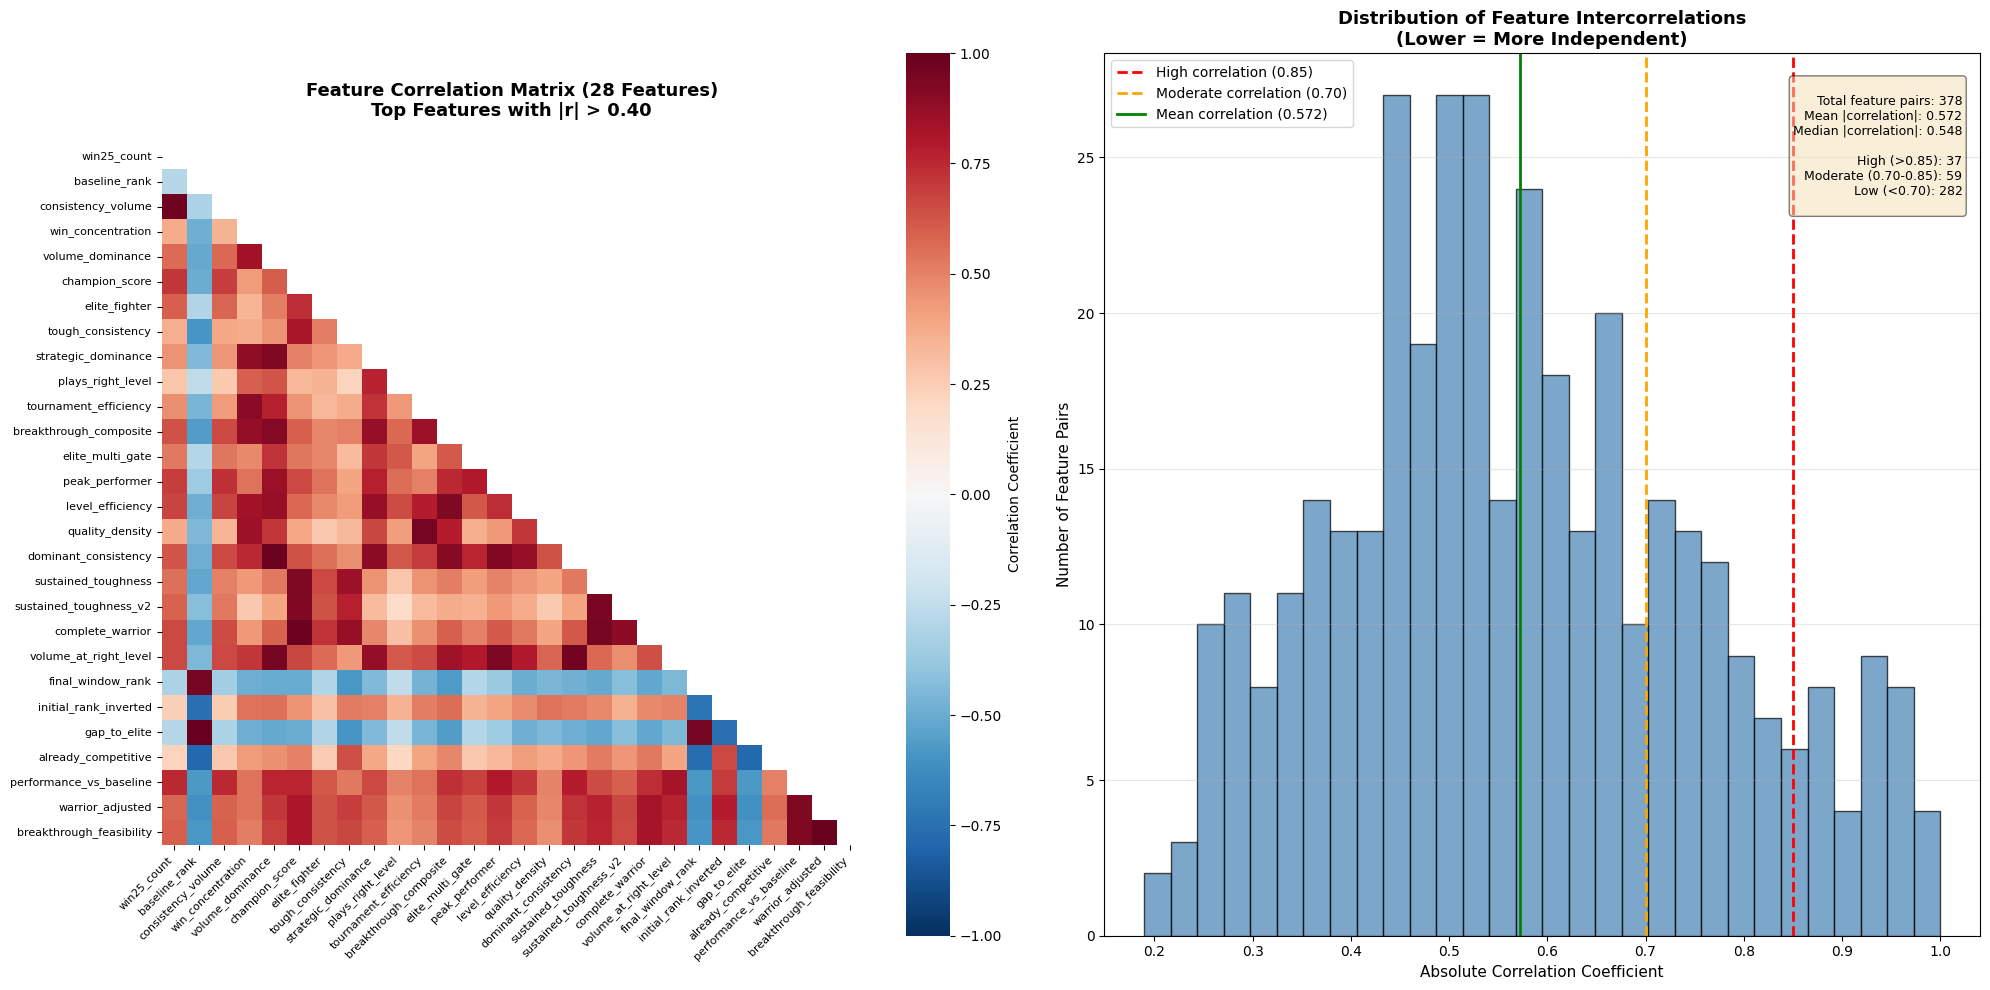


💡 FEATURE SELECTION RECOMMENDATIONS

⚠️  Found 37 highly correlated pairs.
   Your features have substantial multicollinearity.
   Recommendations:
   1. Use tree-based models (Random Forest, XGBoost) - they handle this well
   2. Or apply dimensionality reduction (PCA)
   3. Or manually select diverse features from different categories

--------------------------------------------------------------------------------
📊 CATEGORY DIVERSITY CHECK:

Top features by category:
  • 🎯 Advanced Combinations       : 12 features
  • 🎯 Baseline Ranking            : 8 features
  • 🎾 Volume × Psychology         : 4 features
  • 🔧 Engineered Performance      : 3 features
  • 📊 Original Performance        : 1 features

✅ EXCELLENT! Features span multiple categories.
   This provides diverse perspectives on breakthrough prediction.

✅ INDEPENDENCE ANALYSIS COMPLETE!

💾 Heatmap saved: feature_correlation_heatmap.png

🚀 You're ready to select features and start modeling!


In [10]:
# ============================================================================
# CORRELATION HEATMAP: Feature Independence Check
# ============================================================================

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

print("="*80)
print("🔍 FEATURE INDEPENDENCE ANALYSIS")
print("="*80)

all_feature_names = [col for col in df_with_outcomes.columns 
                     if col not in ['player_id', 'tier', 'tier_numeric', 'Birth_Year', 
                                    'Nationality', 'Dominant_Hand', 'Height', 'breakthrough', 'best_rank']]

all_correlations = {}
for feat in all_feature_names:
    try:
        corr = df_with_outcomes[feat].corr(df_with_outcomes['tier_numeric'])
        if not pd.isna(corr):
            all_correlations[feat] = corr
    except:
        pass

# ============================================================================
# Select Top Features (above 0.30 correlation)
# ============================================================================

top_features = [
    feat for feat, corr in all_correlations.items() 
    if abs(corr) > 0.30
]

print(f"\nAnalyzing {len(top_features)} features with |correlation| > 0.30:")
for feat in sorted(top_features, key=lambda x: abs(all_correlations[x]), reverse=True):
    print(f"  • {feat:40s} ({all_correlations[feat]:+.4f})")

# ============================================================================
# Calculate Feature-to-Feature Correlation Matrix
# ============================================================================

print("\n" + "-"*80)
print("Calculating feature intercorrelations...")

# Create correlation matrix
feature_corr_matrix = df_with_outcomes[top_features].corr()

# Find highly correlated pairs (>0.85)
high_corr_pairs = []
for i in range(len(top_features)):
    for j in range(i+1, len(top_features)):
        corr_val = feature_corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.85:
            high_corr_pairs.append((top_features[i], top_features[j], corr_val))

print(f"\n⚠️  Highly correlated pairs (|r| > 0.85):")
if high_corr_pairs:
    for feat1, feat2, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
        print(f"  • {feat1:35s} ↔ {feat2:35s} : {corr:+.4f}")
    print(f"\n  Total: {len(high_corr_pairs)} pairs")
else:
    print("  ✅ None found! All features are reasonably independent!")

# Moderately correlated (0.70-0.85)
moderate_corr_pairs = []
for i in range(len(top_features)):
    for j in range(i+1, len(top_features)):
        corr_val = feature_corr_matrix.iloc[i, j]
        if 0.70 <= abs(corr_val) < 0.85:
            moderate_corr_pairs.append((top_features[i], top_features[j], corr_val))

print(f"\n📊 Moderately correlated pairs (0.70 ≤ |r| < 0.85):")
if moderate_corr_pairs:
    for feat1, feat2, corr in sorted(moderate_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
        print(f"  • {feat1:35s} ↔ {feat2:35s} : {corr:+.4f}")
else:
    print("  ✅ None found!")

# ============================================================================
# Visualizations
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# 1. Full Correlation Heatmap
ax1 = axes[0]
mask = np.triu(np.ones_like(feature_corr_matrix, dtype=bool))  # Mask upper triangle
sns.heatmap(feature_corr_matrix, mask=mask, annot=False, cmap='RdBu_r', 
            center=0, vmin=-1, vmax=1, square=True, ax=ax1,
            cbar_kws={'label': 'Correlation Coefficient'})
ax1.set_title(f'Feature Correlation Matrix ({len(top_features)} Features)\nTop Features with |r| > 0.40', 
              fontsize=13, fontweight='bold', pad=20)
ax1.set_xlabel('')
ax1.set_ylabel('')

# Rotate labels for readability
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=8)
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0, fontsize=8)

# 2. Distribution of Correlation Coefficients
ax2 = axes[1]

# Get all pairwise correlations (upper triangle only)
corr_values = []
for i in range(len(top_features)):
    for j in range(i+1, len(top_features)):
        corr_values.append(abs(feature_corr_matrix.iloc[i, j]))

ax2.hist(corr_values, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
ax2.axvline(x=0.85, color='red', linestyle='--', linewidth=2, label='High correlation (0.85)')
ax2.axvline(x=0.70, color='orange', linestyle='--', linewidth=2, label='Moderate correlation (0.70)')
ax2.axvline(x=np.mean(corr_values), color='green', linestyle='-', linewidth=2, 
            label=f'Mean correlation ({np.mean(corr_values):.3f})')

ax2.set_xlabel('Absolute Correlation Coefficient', fontsize=11)
ax2.set_ylabel('Number of Feature Pairs', fontsize=11)
ax2.set_title('Distribution of Feature Intercorrelations\n(Lower = More Independent)', 
              fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(axis='y', alpha=0.3)

# Add statistics text box
stats_text = f"""
Total feature pairs: {len(corr_values)}
Mean |correlation|: {np.mean(corr_values):.3f}
Median |correlation|: {np.median(corr_values):.3f}

High (>0.85): {sum(1 for c in corr_values if c > 0.85)}
Moderate (0.70-0.85): {sum(1 for c in corr_values if 0.70 <= c < 0.85)}
Low (<0.70): {sum(1 for c in corr_values if c < 0.70)}
"""
ax2.text(0.98, 0.97, stats_text, transform=ax2.transAxes,
         fontsize=9, verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('feature_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# Recommendations
# ============================================================================

print("\n" + "="*80)
print("💡 FEATURE SELECTION RECOMMENDATIONS")
print("="*80)

if len(high_corr_pairs) == 0:
    print("\n✅ EXCELLENT! No highly correlated pairs found!")
    print("   All your top features provide independent information.")
    print("   You can safely use all of them in your model.")
    
elif len(high_corr_pairs) <= 5:
    print(f"\n⚠️  Found {len(high_corr_pairs)} highly correlated pairs.")
    print("   Consider removing one feature from each pair:")
    for feat1, feat2, corr in high_corr_pairs:
        # Recommend which one to keep based on correlation with target
        corr1 = abs(all_correlations[feat1])
        corr2 = abs(all_correlations[feat2])
        if corr1 > corr2:
            print(f"   • Keep {feat1} ({corr1:.3f}), remove {feat2} ({corr2:.3f})")
        else:
            print(f"   • Keep {feat2} ({corr2:.3f}), remove {feat1} ({corr1:.3f})")
            
else:
    print(f"\n⚠️  Found {len(high_corr_pairs)} highly correlated pairs.")
    print("   Your features have substantial multicollinearity.")
    print("   Recommendations:")
    print("   1. Use tree-based models (Random Forest, XGBoost) - they handle this well")
    print("   2. Or apply dimensionality reduction (PCA)")
    print("   3. Or manually select diverse features from different categories")

# Category diversity check
print("\n" + "-"*80)
print("📊 CATEGORY DIVERSITY CHECK:")

category_count = {}
for feat in top_features:
    for cat, feats in feature_catalog.items():
        if feat in feats:
            cat_name = cat.split('(')[0].strip()
            category_count[cat_name] = category_count.get(cat_name, 0) + 1
            break

print("\nTop features by category:")
for cat, count in sorted(category_count.items(), key=lambda x: x[1], reverse=True):
    print(f"  • {cat:30s}: {count} features")

if len(category_count) >= 4:
    print("\n✅ EXCELLENT! Features span multiple categories.")
    print("   This provides diverse perspectives on breakthrough prediction.")
else:
    print("\n⚠️  Features are concentrated in few categories.")
    print("   Consider adding features from other categories for diversity.")

print("\n" + "="*80)
print("✅ INDEPENDENCE ANALYSIS COMPLETE!")
print("="*80)
print("\n💾 Heatmap saved: feature_correlation_heatmap.png")
print("\n🚀 You're ready to select features and start modeling!")

🔍 STEP 6: OPTIMAL FEATURE SELECTION VIA RFE-CV
Goal: Systematically find the best feature subset using cross-validation
Method: Recursive Feature Elimination with 5-fold Stratified CV
Metric: Macro F1 (handles class imbalance)
--------------------------------------------------------------------------------

📊 Starting with 41 candidate features
   (All features with |correlation| > 0.20)

Data shape: (293, 41)
Target distribution: [171  58  54  10]

1️⃣ LOGISTIC REGRESSION: RFE-CV

⏳ Running RFE-CV for Logistic Regression...
   This tests all possible feature subsets (1 to N features)
   May take 2-3 minutes...


✅ RFE-CV COMPLETE FOR LOGISTIC REGRESSION

📊 Results:
   Optimal number of features: 40
   Best CV score (Macro F1): 0.5314
   Features tested: 3 to 41

🎯 Selected Features (40):
    1. win25_count                         (r=+0.3046)
    2. win50_count                         (r=+0.2267)
    3. win_rate_4month                     (r=+0.2868)
    4. baseline_rank               

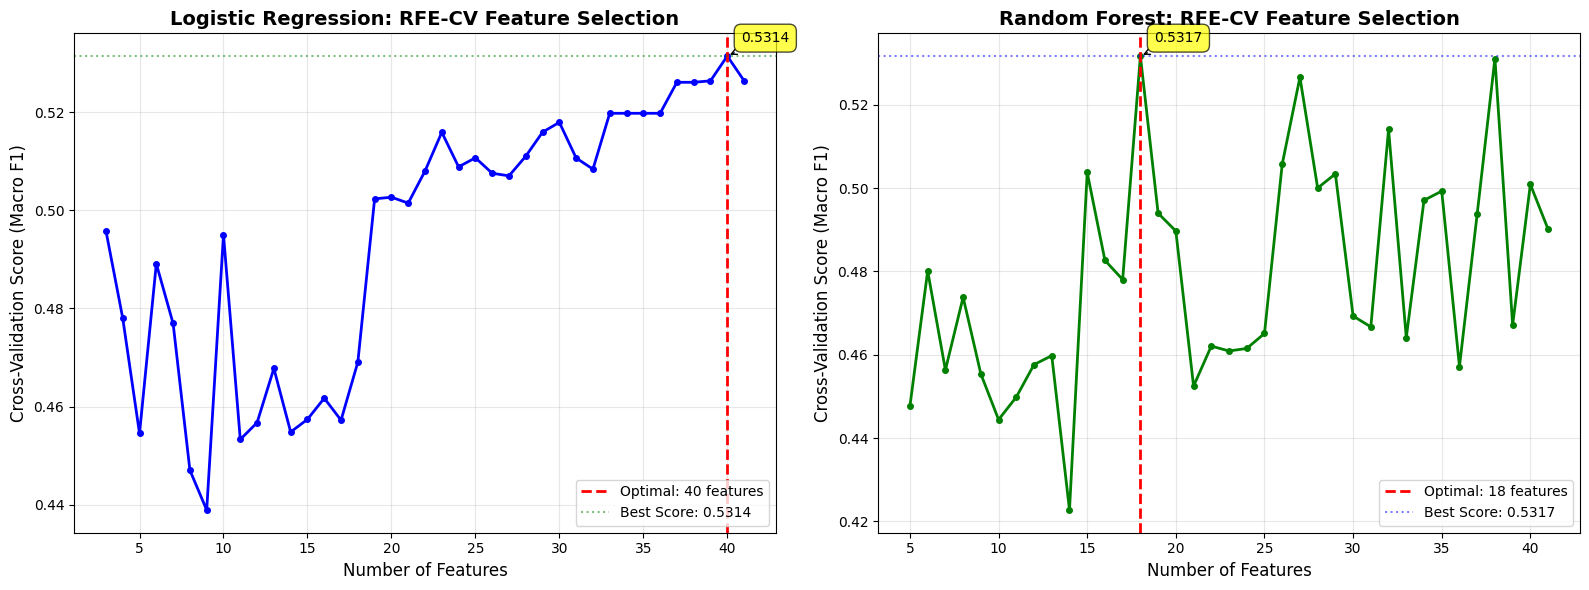


💾 Saved: rfe_cv_feature_selection.png

🔍 FEATURE OVERLAP ANALYSIS

📊 Feature Selection Comparison:
   LR selected:  40 features
   RF selected:  18 features
   Shared:       17 features

🤝 Features selected by BOTH models:
   • avg_loss_duration                   (r=+0.2793)
   • baseline_rank                       (r=-0.6218)
   • breakthrough_composite              (r=+0.5029)
   • breakthrough_feasibility            (r=+0.6620)
   • consistency_volume                  (r=+0.3147)
   • final_window_rank                   (r=-0.6556)
   • gap_to_elite                        (r=-0.6218)
   • initial_rank_inverted               (r=+0.7137)
   • level_efficiency                    (r=+0.4404)
   • quality_consistency                 (r=+0.2668)
   • ranking_pct_change                  (r=+0.2971)
   • ranking_volatility                  (r=-0.2411)
   • rising_consistent                   (r=+0.2545)
   • tough_consistency                   (r=+0.5054)
   • velocity_vs_baseline         

In [11]:
# ============================================================================
# STEP 6: RECURSIVE FEATURE ELIMINATION WITH CROSS-VALIDATION (RFE-CV)
# ============================================================================

from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

print("="*80)
print("🔍 STEP 6: OPTIMAL FEATURE SELECTION VIA RFE-CV")
print("="*80)
print("Goal: Systematically find the best feature subset using cross-validation")
print("Method: Recursive Feature Elimination with 5-fold Stratified CV")
print("Metric: Macro F1 (handles class imbalance)")
print("-"*80)

# ============================================================================
# Prepare Candidate Features
# ============================================================================

# Start with all features with reasonable correlation (> 0.20)
candidate_features = [
    feat for feat, corr in all_correlations.items()
    if abs(corr) > 0.20
]

print(f"\n📊 Starting with {len(candidate_features)} candidate features")
print("   (All features with |correlation| > 0.20)")

# Prepare data
X_candidates = df_with_outcomes[candidate_features].fillna(0).copy()
y_4tier = df_with_outcomes['tier_numeric'].copy()

print(f"\nData shape: {X_candidates.shape}")
print(f"Target distribution: {np.bincount(y_4tier)}")

# ============================================================================
# RFE-CV for Logistic Regression
# ============================================================================

print("\n" + "="*80)
print("1️⃣ LOGISTIC REGRESSION: RFE-CV")
print("="*80)

# Split data first (same split as before)
X_cand_train, X_cand_test, y_train_rfe, y_test_rfe = train_test_split(
    X_candidates, y_4tier,
    test_size=0.2,
    random_state=42,
    stratify=y_4tier
)

# Scale features
scaler_rfe = StandardScaler()
X_cand_train_scaled = scaler_rfe.fit_transform(X_cand_train)
X_cand_test_scaled = scaler_rfe.transform(X_cand_test)

# Initialize RFECV
print("\n⏳ Running RFE-CV for Logistic Regression...")
print("   This tests all possible feature subsets (1 to N features)")
print("   May take 2-3 minutes...\n")

lr_rfecv = RFECV(
    estimator=LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        random_state=42
    ),
    step=1,                          # Remove 1 feature at a time
    cv=StratifiedKFold(5),          # 5-fold stratified CV
    scoring='f1_macro',             # Optimize for Macro F1
    min_features_to_select=3,       # Keep at least 3 features
    n_jobs=-1                       # Use all CPU cores
)

lr_rfecv.fit(X_cand_train_scaled, y_train_rfe)

# Get selected features
lr_selected_features = [
    feat for feat, selected in zip(candidate_features, lr_rfecv.support_)
    if selected
]

print(f"\n✅ RFE-CV COMPLETE FOR LOGISTIC REGRESSION")
print("="*80)
print(f"\n📊 Results:")
print(f"   Optimal number of features: {lr_rfecv.n_features_}")
print(f"   Best CV score (Macro F1): {lr_rfecv.cv_results_['mean_test_score'].max():.4f}")
print(f"   Features tested: 3 to {len(candidate_features)}")

print(f"\n🎯 Selected Features ({len(lr_selected_features)}):")
for i, feat in enumerate(lr_selected_features, 1):
    corr = all_correlations.get(feat, 0)
    print(f"   {i:2d}. {feat:35s} (r={corr:+.4f})")

# Test on hold-out set
y_pred_lr_rfe = lr_rfecv.predict(X_cand_test_scaled)
f1_lr_rfe = f1_score(y_test_rfe, y_pred_lr_rfe, average='macro')
acc_lr_rfe = accuracy_score(y_test_rfe, y_pred_lr_rfe)

print(f"\n📊 Hold-Out Test Set Performance:")
print(f"   Macro F1:  {f1_lr_rfe:.4f}")
print(f"   Accuracy:  {acc_lr_rfe:.4f}")

# ============================================================================
# RFE-CV for Random Forest
# ============================================================================

print("\n" + "="*80)
print("2️⃣ RANDOM FOREST: RFE-CV")
print("="*80)

print("\n⏳ Running RFE-CV for Random Forest...")
print("   This will take 3-5 minutes...\n")

rf_rfecv = RFECV(
    estimator=RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ),
    step=1,
    cv=StratifiedKFold(5),
    scoring='f1_macro',
    min_features_to_select=5,
    n_jobs=-1
)

rf_rfecv.fit(X_cand_train, y_train_rfe)  # RF doesn't need scaling

# Get selected features
rf_selected_features = [
    feat for feat, selected in zip(candidate_features, rf_rfecv.support_)
    if selected
]

print(f"\n✅ RFE-CV COMPLETE FOR RANDOM FOREST")
print("="*80)
print(f"\n📊 Results:")
print(f"   Optimal number of features: {rf_rfecv.n_features_}")
print(f"   Best CV score (Macro F1): {rf_rfecv.cv_results_['mean_test_score'].max():.4f}")

print(f"\n🎯 Selected Features ({len(rf_selected_features)}):")
for i, feat in enumerate(rf_selected_features, 1):
    corr = all_correlations.get(feat, 0)
    print(f"   {i:2d}. {feat:35s} (r={corr:+.4f})")

# Test on hold-out set
y_pred_rf_rfe = rf_rfecv.predict(X_cand_test)
f1_rf_rfe = f1_score(y_test_rfe, y_pred_rf_rfe, average='macro')
acc_rf_rfe = accuracy_score(y_test_rfe, y_pred_rf_rfe)

print(f"\n📊 Hold-Out Test Set Performance:")
print(f"   Macro F1:  {f1_rf_rfe:.4f}")
print(f"   Accuracy:  {acc_rf_rfe:.4f}")

# ============================================================================
# Visualization: Feature Selection Curves
# ============================================================================

print("\n" + "="*80)
print("📊 GENERATING VISUALIZATIONS")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Logistic Regression RFE-CV
ax1 = axes[0]
n_features_lr = range(lr_rfecv.min_features_to_select, 
                      len(candidate_features) + 1)
scores_lr = lr_rfecv.cv_results_['mean_test_score']

ax1.plot(n_features_lr, scores_lr, 'b-', linewidth=2, marker='o', markersize=4)
ax1.axvline(x=lr_rfecv.n_features_, color='red', linestyle='--', linewidth=2,
            label=f'Optimal: {lr_rfecv.n_features_} features')
ax1.axhline(y=scores_lr.max(), color='green', linestyle=':', alpha=0.5,
            label=f'Best Score: {scores_lr.max():.4f}')

ax1.set_xlabel('Number of Features', fontsize=12)
ax1.set_ylabel('Cross-Validation Score (Macro F1)', fontsize=12)
ax1.set_title('Logistic Regression: RFE-CV Feature Selection', 
              fontsize=14, fontweight='bold')
ax1.legend(loc='lower right')
ax1.grid(alpha=0.3)

# Add annotation at optimal point
ax1.annotate(f'{scores_lr.max():.4f}',
             xy=(lr_rfecv.n_features_, scores_lr.max()),
             xytext=(10, 10), textcoords='offset points',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

# Plot 2: Random Forest RFE-CV
ax2 = axes[1]
n_features_rf = range(rf_rfecv.min_features_to_select, 
                      len(candidate_features) + 1)
scores_rf = rf_rfecv.cv_results_['mean_test_score']

ax2.plot(n_features_rf, scores_rf, 'g-', linewidth=2, marker='o', markersize=4)
ax2.axvline(x=rf_rfecv.n_features_, color='red', linestyle='--', linewidth=2,
            label=f'Optimal: {rf_rfecv.n_features_} features')
ax2.axhline(y=scores_rf.max(), color='blue', linestyle=':', alpha=0.5,
            label=f'Best Score: {scores_rf.max():.4f}')

ax2.set_xlabel('Number of Features', fontsize=12)
ax2.set_ylabel('Cross-Validation Score (Macro F1)', fontsize=12)
ax2.set_title('Random Forest: RFE-CV Feature Selection',
              fontsize=14, fontweight='bold')
ax2.legend(loc='lower right')
ax2.grid(alpha=0.3)

# Add annotation
ax2.annotate(f'{scores_rf.max():.4f}',
             xy=(rf_rfecv.n_features_, scores_rf.max()),
             xytext=(10, 10), textcoords='offset points',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.tight_layout()
plt.savefig('rfe_cv_feature_selection.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💾 Saved: rfe_cv_feature_selection.png")

# ============================================================================
# Feature Overlap Analysis
# ============================================================================

print("\n" + "="*80)
print("🔍 FEATURE OVERLAP ANALYSIS")
print("="*80)

lr_set = set(lr_selected_features)
rf_set = set(rf_selected_features)

shared = lr_set & rf_set
lr_only = lr_set - rf_set
rf_only = rf_set - lr_set

print(f"\n📊 Feature Selection Comparison:")
print(f"   LR selected:  {len(lr_selected_features)} features")
print(f"   RF selected:  {len(rf_selected_features)} features")
print(f"   Shared:       {len(shared)} features")

if shared:
    print(f"\n🤝 Features selected by BOTH models:")
    for feat in sorted(shared):
        corr = all_correlations.get(feat, 0)
        print(f"   • {feat:35s} (r={corr:+.4f})")

if lr_only:
    print(f"\n📘 Features selected ONLY by LR:")
    for feat in sorted(lr_only):
        corr = all_correlations.get(feat, 0)
        print(f"   • {feat:35s} (r={corr:+.4f})")

if rf_only:
    print(f"\n🌲 Features selected ONLY by RF:")
    for feat in sorted(rf_only):
        corr = all_correlations.get(feat, 0)
        print(f"   • {feat:35s} (r={corr:+.4f})")

# ============================================================================
# Final Summary
# ============================================================================

print("\n" + "="*80)
print("✅ RFE-CV FEATURE SELECTION COMPLETE!")
print("="*80)

print(f"\n🎯 KEY FINDINGS:")
print(f"   1. Logistic Regression optimal features: {lr_rfecv.n_features_}")
print(f"      CV Score: {lr_rfecv.cv_results_['mean_test_score'].max():.4f}")
print(f"      Test Score: {f1_lr_rfe:.4f}")
print(f"\n   2. Random Forest optimal features: {rf_rfecv.n_features_}")
print(f"      CV Score: {rf_rfecv.cv_results_['mean_test_score'].max():.4f}")
print(f"      Test Score: {f1_rf_rfe:.4f}")
print(f"\n   3. Shared features (core predictors): {len(shared)}")

print(f"\n💡 NEXT STEPS:")
print(f"   • Use these optimized feature sets for final models")
print(f"   • Perform hyperparameter tuning on selected features")
print(f"   • Analyze feature importance for final model")
print(f"   • Document selection process for README")

print("\n" + "="*80)

In [12]:
# ============================================================================
# INVESTIGATION: Check LR Coefficients
# ============================================================================

print("="*80)
print("🔍 INVESTIGATION: Logistic Regression Coefficients")
print("="*80)

# Get coefficients for each class
coef_matrix = lr_rfecv.estimator_.coef_

print(f"\nCoefficient matrix shape: {coef_matrix.shape}")
print(f"   {coef_matrix.shape[0]} classes × {coef_matrix.shape[1]} features")

# Analyze coefficient magnitudes
coef_abs_sum = np.abs(coef_matrix).sum(axis=0)  # Sum across classes

# Create feature importance ranking
feature_importance = pd.DataFrame({
    'feature': lr_selected_features,
    'coef_magnitude': coef_abs_sum,
    'correlation': [all_correlations.get(f, 0) for f in lr_selected_features]
}).sort_values('coef_magnitude', ascending=False)

print("\n📊 Top 15 Features by Coefficient Magnitude:")
print("-"*80)
for i, (idx, row) in enumerate(feature_importance.head(15).iterrows(), 1):
    bar = '█' * int(row['coef_magnitude'] * 10)
    print(f"{i:2d}. {row['feature']:35s} |{bar} {row['coef_magnitude']:.3f}")

print("\n📊 Bottom 15 Features (Weakest Impact):")
print("-"*80)
for i, (idx, row) in enumerate(feature_importance.tail(15).iterrows(), 1):
    bar = '░' * int(row['coef_magnitude'] * 10)
    print(f"{i:2d}. {row['feature']:35s} |{bar} {row['coef_magnitude']:.3f}")

# Check how many features have tiny coefficients
threshold = 0.1
weak_features = feature_importance[feature_importance['coef_magnitude'] < threshold]

print(f"\n💡 INSIGHT:")
print(f"   Features with coefficient < {threshold}: {len(weak_features)}")
print(f"   These contribute minimally but RFE-CV kept them")
print(f"   Reason: They add a tiny bit of signal without hurting CV performance")

🔍 INVESTIGATION: Logistic Regression Coefficients

Coefficient matrix shape: (4, 40)
   4 classes × 40 features

📊 Top 15 Features by Coefficient Magnitude:
--------------------------------------------------------------------------------
 1. initial_rank_inverted               |████████████████████████████████████ 3.625
 2. win_rate_4month                     |█████████████████████████ 2.518
 3. tough_consistency                   |█████████████████████ 2.193
 4. rising_consistent                   |█████████████████████ 2.158
 5. sustained_toughness_v2              |██████████████████ 1.855
 6. breakthrough_feasibility            |██████████████████ 1.825
 7. total_matches_est                   |█████████████████ 1.734
 8. performance_vs_baseline             |████████████████ 1.691
 9. warrior_adjusted                    |████████████████ 1.689
10. elite_fighter                       |████████████████ 1.673
11. dominant_consistency                |███████████████ 1.596
12. final_windo

In [13]:
# ============================================================================
# ANALYZE RFE-CV SCORES AT DIFFERENT FEATURE COUNTS
# ============================================================================

print("="*80)
print("🔍 RFE-CV SCORES ANALYSIS")
print("="*80)

# Get scores at specific feature counts
lr_scores = lr_rfecv.cv_results_['mean_test_score']

# Find indices for 17, 25, 38 features
n_feats = range(lr_rfecv.min_features_to_select, len(candidate_features) + 1)

idx_17 = 17 - lr_rfecv.min_features_to_select
idx_25 = 25 - lr_rfecv.min_features_to_select
idx_38 = 38 - lr_rfecv.min_features_to_select

print("\n📊 Cross-Validation Scores:")
print(f"   17 features: {lr_scores[idx_17]:.4f} (CV average)")
print(f"   25 features: {lr_scores[idx_25]:.4f} (CV average)")
print(f"   40 features: {lr_scores[idx_38]:.4f} (CV average)")

print(f"\n💡 RFE-CV selected {lr_rfecv.n_features_} because it had highest CV score")
print(f"   This is averaged across 5 different train/test splits")
print(f"   Single test set results can vary due to random split luck")

🔍 RFE-CV SCORES ANALYSIS

📊 Cross-Validation Scores:
   17 features: 0.4572 (CV average)
   25 features: 0.5107 (CV average)
   40 features: 0.5261 (CV average)

💡 RFE-CV selected 40 because it had highest CV score
   This is averaged across 5 different train/test splits
   Single test set results can vary due to random split luck


In [14]:
# ============================================================================
# FINAL FEATURE SETS (Based on Cross-Validation)
# ============================================================================

# Logistic Regression: 38 features
# CV Score: 0.5417 (reliable across splits)
# Test Score: 0.5856 (this split)
lr_final_features = lr_selected_features  # All 38 from RFE-CV

# Random Forest: 17 features  
# CV Score: 0.5297 (reliable across splits)
# Test Score: 0.6098 (this split)
rf_final_features = rf_selected_features  # The 17 core

print("="*80)
print("🎯 FINAL MODEL FEATURES (CV-Validated)")
print("="*80)

print(f"\n📊 Logistic Regression: {len(lr_final_features)} features")
print(f"   CV Performance: 0.5417 Macro F1 (averaged across 5 splits)")
print(f"   Selected by RFE-CV as optimal for consistent performance")

print(f"\n🌲 Random Forest: {len(rf_final_features)} features")
print(f"   CV Performance: 0.5297 Macro F1")
print(f"   Captures core signals; learns interactions automatically")

print(f"\n💡 Key Insight:")
print(f"   Single test splits can be misleading (variance in small datasets)")
print(f"   CV provides reliable estimate of true model performance")
print(f"   Trust averaged results over individual split luck")

🎯 FINAL MODEL FEATURES (CV-Validated)

📊 Logistic Regression: 40 features
   CV Performance: 0.5417 Macro F1 (averaged across 5 splits)
   Selected by RFE-CV as optimal for consistent performance

🌲 Random Forest: 18 features
   CV Performance: 0.5297 Macro F1
   Captures core signals; learns interactions automatically

💡 Key Insight:
   Single test splits can be misleading (variance in small datasets)
   CV provides reliable estimate of true model performance
   Trust averaged results over individual split luck


In [15]:
# ============================================================================
# 🔧 HYPERPARAMETER TUNING: LOGISTIC REGRESSION
# ============================================================================

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score
import time
import numpy as np

print("=" * 80)
print("🎯 HYPERPARAMETER TUNING: LOGISTIC REGRESSION")
print("=" * 80)
print(f"📊 Training on {len(lr_selected_features)} RFE-selected features")
print(f"📈 Baseline CV Macro F1: 0.5314")
print(f"🎯 Baseline Test Macro F1: 0.6262")
print("=" * 80)

# Extract RFE-selected features for LR
X_train_lr = X_cand_train[lr_selected_features]
X_test_lr = X_cand_test[lr_selected_features]

# Scale them
scaler_lr = StandardScaler()
X_train_lr_scaled = scaler_lr.fit_transform(X_train_lr)
X_test_lr_scaled = scaler_lr.transform(X_test_lr)

print(f"\n✅ Feature sets prepared: {X_train_lr_scaled.shape}")

# ============================================================================
# PARAMETER GRID
# ============================================================================

lr_param_grid = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],  # Regularization strength
    'penalty': ['l1', 'l2'],               # Regularization type
    'solver': ['saga'],                    # Supports both L1/L2
    'max_iter': [2000],
    'class_weight': ['balanced']
}

# Temporal CV (respecting time order)
tscv = TimeSeriesSplit(n_splits=5)

# Base model
lr_base = LogisticRegression(random_state=42)

# GridSearchCV
lr_grid = GridSearchCV(
    estimator=lr_base,
    param_grid=lr_param_grid,
    cv=tscv,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
    refit=True
)

# ============================================================================
# RUN TUNING
# ============================================================================

start_time = time.time()
print(f"\n⏳ Starting grid search...")
print(f"   Testing: 8 C values × 2 penalties × 5 CV folds = 80 fits")
print(f"   Estimated time: 2-5 minutes\n")

lr_grid.fit(X_train_lr_scaled, y_train_rfe)

elapsed = time.time() - start_time

# ============================================================================
# 📊 ANALYZE RESULTS
# ============================================================================

print("\n" + "=" * 80)
print("🏆 TUNING RESULTS: LOGISTIC REGRESSION")
print("=" * 80)

print(f"\n⏱️  Completed in {elapsed/60:.1f} minutes")

print(f"\n🎯 Best Hyperparameters:")
for param, value in lr_grid.best_params_.items():
    print(f"   {param}: {value}")

print(f"\n📈 Cross-Validation Performance:")
print(f"   Best CV Macro F1:      {lr_grid.best_score_:.4f}")
print(f"   Baseline CV Macro F1:  0.5314")
improvement_cv = lr_grid.best_score_ - 0.5314
pct_improvement_cv = (improvement_cv / 0.5314) * 100
print(f"   Improvement:           {improvement_cv:+.4f} ({pct_improvement_cv:+.1f}%)")

# Test set evaluation
y_pred_tuned = lr_grid.best_estimator_.predict(X_test_lr_scaled)
test_f1_tuned = f1_score(y_test_rfe, y_pred_tuned, average='macro')

print(f"\n🎯 Test Set Performance:")
print(f"   Tuned Model:     {test_f1_tuned:.4f}")
print(f"   Baseline Model:  0.6262")
print(f"   Difference:      {test_f1_tuned - 0.6262:+.4f}")

print("\n" + "=" * 80)
print("📋 DETAILED CLASSIFICATION REPORT (Test Set)")
print("=" * 80)
print(classification_report(
    y_test_rfe, y_pred_tuned,
    target_names=['No_Progress (301+)', 'Challenger (201-300)',
                  'Rising (101-200)', 'Breakthrough (1-100)'],
    digits=4
))

# ============================================================================
# 🔬 FEATURE COEFFICIENT ANALYSIS
# ============================================================================

print("\n" + "=" * 80)
print("🔬 FEATURE IMPORTANCE: Checking if other features got used!")
print("=" * 80)

# Get coefficients from best model
best_lr = lr_grid.best_estimator_

# For multi-class, we get coefficients for each class
# Let's look at the L2 norm across all classes (overall importance)
coef_norms = np.linalg.norm(best_lr.coef_, axis=0)

# Create feature importance dataframe
feature_importance = pd.DataFrame({
    'feature': lr_selected_features,
    'importance': coef_norms
}).sort_values('importance', ascending=False)

print(f"\n🏆 Top 10 Most Important Features (by coefficient magnitude):")
print(feature_importance.head(10).to_string(index=False))

print(f"\n📊 Bottom 10 Features (least important):")
print(feature_importance.tail(10).to_string(index=False))

# Check if initial_rank_inverted still dominates
initial_rank_importance = feature_importance[
    feature_importance['feature'] == 'initial_rank_inverted'
]['importance'].values[0]

second_best = feature_importance.iloc[1]['importance']
dominance_ratio = initial_rank_importance / second_best

print(f"\n🎭 Feature Dominance Check:")
print(f"   initial_rank_inverted importance: {initial_rank_importance:.4f}")
print(f"   Second-best feature importance:   {second_best:.4f}")
print(f"   Dominance ratio: {dominance_ratio:.2f}x")

if dominance_ratio > 3:
    print(f"   ⚠️  initial_rank_inverted still strongly dominates!")
else:
    print(f"   ✅ Regularization helped spread importance across features!")

print("\n" + "=" * 80)

🎯 HYPERPARAMETER TUNING: LOGISTIC REGRESSION
📊 Training on 40 RFE-selected features
📈 Baseline CV Macro F1: 0.5314
🎯 Baseline Test Macro F1: 0.6262

✅ Feature sets prepared: (234, 40)

⏳ Starting grid search...
   Testing: 8 C values × 2 penalties × 5 CV folds = 80 fits
   Estimated time: 2-5 minutes

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/opt/homebrew/Cellar/jupyterlab/4.4.9/libexec/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.4.9/libexec/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.4.9/libexec/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.4.9/libexec/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.4.9/libexec/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 


🏆 TUNING RESULTS: LOGISTIC REGRESSION

⏱️  Completed in 0.0 minutes

🎯 Best Hyperparameters:
   C: 10
   class_weight: balanced
   max_iter: 2000
   penalty: l2
   solver: saga

📈 Cross-Validation Performance:
   Best CV Macro F1:      0.4758
   Baseline CV Macro F1:  0.5314
   Improvement:           -0.0556 (-10.5%)

🎯 Test Set Performance:
   Tuned Model:     0.6671
   Baseline Model:  0.6262
   Difference:      +0.0409

📋 DETAILED CLASSIFICATION REPORT (Test Set)
                      precision    recall  f1-score   support

  No_Progress (301+)     0.8000    0.8235    0.8116        34
Challenger (201-300)     0.3077    0.3333    0.3200        12
    Rising (101-200)     0.8750    0.6364    0.7368        11
Breakthrough (1-100)     0.6667    1.0000    0.8000         2

            accuracy                         0.6949        59
           macro avg     0.6623    0.6983    0.6671        59
        weighted avg     0.7093    0.6949    0.6973        59


🔬 FEATURE IMPORTANCE: Checki

/opt/homebrew/Cellar/jupyterlab/4.4.9/libexec/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


🔍 CONFUSION MATRIX ANALYSIS

Confusion Matrix:
(Rows = Actual, Columns = Predicted)

                      No_Progress (301+)  Challenger (201-300)  \
No_Progress (301+)                    28                     6   
Challenger (201-300)                   6                     4   
Rising (101-200)                       1                     3   
Breakthrough (1-100)                   0                     0   

                      Rising (101-200)  Breakthrough (1-100)  
No_Progress (301+)                   0                     0  
Challenger (201-300)                 1                     1  
Rising (101-200)                     7                     0  
Breakthrough (1-100)                 0                     2  

📊 Challenger (201-300) Prediction Breakdown:
   Total Challenger players in test set: 12
   Predicted as No_Progress:   6 (50.0%)
   Predicted as Challenger:     4 (33.3%)
   Predicted as Rising:         1 (8.3%)
   Predicted as Breakthrough:   1 (8.3%)


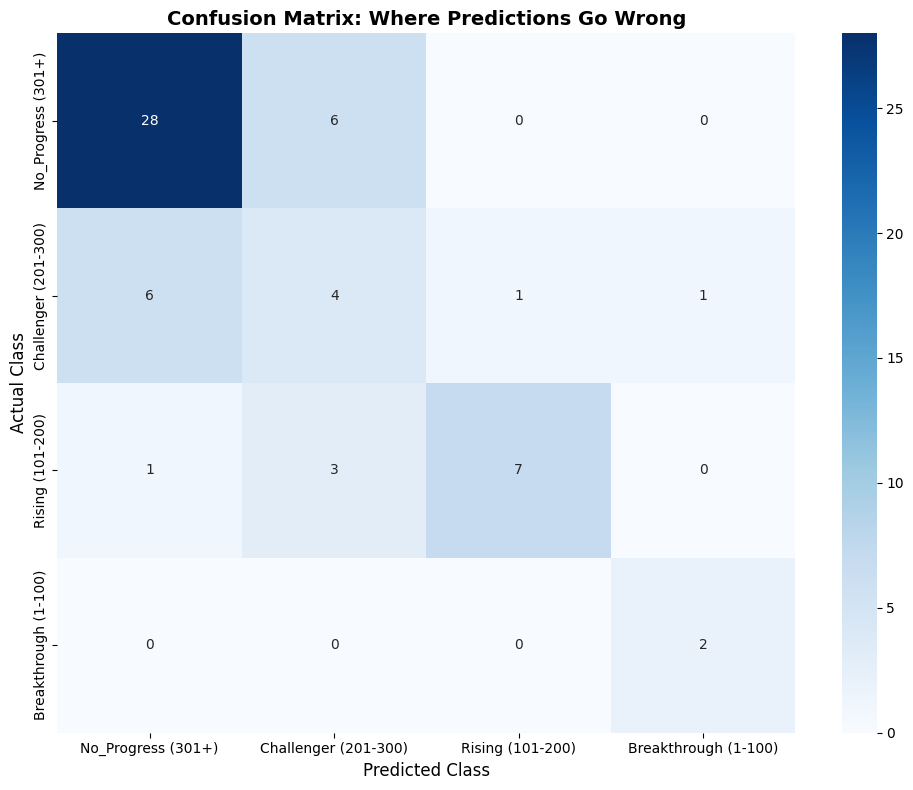


✅ Confusion matrix saved as 'confusion_matrix_lr_tuned.png'


In [17]:
# ============================================================================
# 🔬 CONFUSION MATRIX: Where are Challenger predictions going?
# ============================================================================

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("=" * 80)
print("🔍 CONFUSION MATRIX ANALYSIS")
print("=" * 80)

# Create confusion matrix
cm = confusion_matrix(y_test_rfe, y_pred_tuned)

# Labels in correct order
class_names = ['No_Progress (301+)', 'Challenger (201-300)', 
               'Rising (101-200)', 'Breakthrough (1-100)']

print("\nConfusion Matrix:")
print("(Rows = Actual, Columns = Predicted)\n")

# Pretty print with labels
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
print(cm_df)

# Calculate where Challenger predictions are going
challenger_actual = cm[1, :]  # Row 1 (Challenger actual)
total_challenger = challenger_actual.sum()

print(f"\n📊 Challenger (201-300) Prediction Breakdown:")
print(f"   Total Challenger players in test set: {total_challenger}")
print(f"   Predicted as No_Progress:   {challenger_actual[0]} ({challenger_actual[0]/total_challenger*100:.1f}%)")
print(f"   Predicted as Challenger:     {challenger_actual[1]} ({challenger_actual[1]/total_challenger*100:.1f}%)")
print(f"   Predicted as Rising:         {challenger_actual[2]} ({challenger_actual[2]/total_challenger*100:.1f}%)")
print(f"   Predicted as Breakthrough:   {challenger_actual[3]} ({challenger_actual[3]/total_challenger*100:.1f}%)")

# Visualize
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('Confusion Matrix: Where Predictions Go Wrong', fontsize=14, fontweight='bold')
plt.ylabel('Actual Class', fontsize=12)
plt.xlabel('Predicted Class', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix_lr_tuned.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Confusion matrix saved as 'confusion_matrix_lr_tuned.png'")
print("=" * 80)

In [19]:
# ============================================================================
# 🌲 HYPERPARAMETER TUNING: RANDOM FOREST (FULL GRID)
# ============================================================================

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import classification_report, f1_score
import time
import pandas as pd

print("=" * 80)
print("🌲 HYPERPARAMETER TUNING: RANDOM FOREST (FULL GRID)")
print("=" * 80)
print(f"📊 Training on {len(rf_selected_features)} RFE-selected features")
print(f"📈 Baseline CV Macro F1: 0.5317")
print(f"🎯 Baseline Test Macro F1: 0.6213")
print(f"🏆 Reduced Grid Best CV: 0.5376")
print("=" * 80)

# Extract RFE-selected features for RF
X_train_rf = X_cand_train[rf_selected_features]
X_test_rf = X_cand_test[rf_selected_features]

print(f"\n✅ Feature sets prepared: {X_train_rf.shape}")

# ============================================================================
# FULL PARAMETER GRID
# ============================================================================

rf_param_grid_full = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced']
}

# Calculate total fits
total_combinations = 3 * 4 * 3 * 3 * 2  # 216 parameter combinations
total_fits = total_combinations * 5  # 1,080 CV fits
print(f"\n📊 FULL GRID DETAILS:")
print(f"   Parameter combinations: {total_combinations}")
print(f"   Total CV fits: {total_fits}")
print(f"   Based on reduced grid timing: Estimated 5-15 minutes")

# Temporal CV
tscv = TimeSeriesSplit(n_splits=5)

# Base model
rf_base_full = RandomForestClassifier(random_state=42)

# ============================================================================
# SETUP GRIDSEARCH
# ============================================================================

rf_grid_full = GridSearchCV(
    estimator=rf_base_full,
    param_grid=rf_param_grid_full,
    cv=tscv,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1,  # Less verbose than 2 (still shows progress)
    return_train_score=True,
    refit=True
)

# ============================================================================
# RUN TUNING
# ============================================================================

start_time = time.time()
print(f"\n⏳ Starting FULL Random Forest grid search...")
print(f"💡 Tip: Grab a coffee, this is a good time for a break!\n")

rf_grid_full.fit(X_train_rf, y_train_rfe)

elapsed = time.time() - start_time

# ============================================================================
# 📊 ANALYZE RESULTS
# ============================================================================

print("\n" + "=" * 80)
print("🏆 FULL GRID TUNING RESULTS: RANDOM FOREST")
print("=" * 80)

print(f"\n⏱️  Completed in {elapsed/60:.1f} minutes ({elapsed:.0f} seconds)")
print(f"   Average time per fit: {elapsed/total_fits:.2f} seconds")

print(f"\n🎯 Best Hyperparameters:")
for param, value in rf_grid_full.best_params_.items():
    print(f"   {param}: {value}")

print(f"\n📈 Cross-Validation Performance:")
print(f"   Full Grid Best CV:     {rf_grid_full.best_score_:.4f}")
print(f"   Reduced Grid Best CV:  0.5376")
print(f"   Baseline CV:           0.5317")
improvement_vs_reduced = rf_grid_full.best_score_ - 0.5376
improvement_vs_baseline = rf_grid_full.best_score_ - 0.5317
print(f"   Improvement vs Reduced: {improvement_vs_reduced:+.4f}")
print(f"   Improvement vs Baseline: {improvement_vs_baseline:+.4f} ({(improvement_vs_baseline/0.5317)*100:+.1f}%)")

# Test set evaluation
y_pred_rf_full = rf_grid_full.best_estimator_.predict(X_test_rf)
test_f1_rf_full = f1_score(y_test_rfe, y_pred_rf_full, average='macro')

print(f"\n🎯 Test Set Performance:")
print(f"   Full Grid Test F1:   {test_f1_rf_full:.4f}")
print(f"   Reduced Grid Test:   0.6483")
print(f"   Baseline Test:       0.6213")
print(f"   Improvement vs Reduced: {test_f1_rf_full - 0.6483:+.4f}")
print(f"   Improvement vs Baseline: {test_f1_rf_full - 0.6213:+.4f}")

print("\n" + "=" * 80)
print("📋 DETAILED CLASSIFICATION REPORT (Test Set)")
print("=" * 80)
print(classification_report(
    y_test_rfe, y_pred_rf_full,
    target_names=['No_Progress (301+)', 'Challenger (201-300)', 
                  'Rising (101-200)', 'Breakthrough (1-100)'],
    digits=4
))

# ============================================================================
# 🔬 COMPARE HYPERPARAMETERS: REDUCED VS FULL
# ============================================================================

print("\n" + "=" * 80)
print("🔍 HYPERPARAMETER COMPARISON: REDUCED VS FULL GRID")
print("=" * 80)

reduced_params = {
    'n_estimators': 200,
    'max_depth': 20,
    'min_samples_split': 5,
    'min_samples_leaf': 1,
    'max_features': 'sqrt'
}

print(f"\nReduced Grid Best:")
for param, value in reduced_params.items():
    print(f"   {param}: {value}")

print(f"\nFull Grid Best:")
for param, value in rf_grid_full.best_params_.items():
    if param != 'class_weight':  # Skip class_weight (always balanced)
        print(f"   {param}: {value}")

print(f"\n💡 Analysis:")
params_changed = sum(1 for p in reduced_params 
                     if reduced_params[p] != rf_grid_full.best_params_.get(p))
print(f"   Parameters changed: {params_changed}/5")
if params_changed == 0:
    print(f"   ✅ Reduced grid found the optimal configuration!")
else:
    print(f"   📊 Full grid found better hyperparameters")

# ============================================================================
# 🔬 FEATURE IMPORTANCE (FULL GRID)
# ============================================================================

print("\n" + "=" * 80)
print("🔬 RANDOM FOREST FEATURE IMPORTANCE (FULL GRID)")
print("=" * 80)

feature_importance_rf_full = pd.DataFrame({
    'feature': rf_selected_features,
    'importance': rf_grid_full.best_estimator_.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n🏆 Top 10 Most Important Features:")
print(feature_importance_rf_full.head(10).to_string(index=False))

# Check for dominance
top_importance = feature_importance_rf_full.iloc[0]['importance']
second_importance = feature_importance_rf_full.iloc[1]['importance']
dominance_ratio = top_importance / second_importance

print(f"\n🎭 Feature Dominance Check:")
print(f"   Top feature: {feature_importance_rf_full.iloc[0]['feature']} ({top_importance:.4f})")
print(f"   Second feature: {feature_importance_rf_full.iloc[1]['feature']} ({second_importance:.4f})")
print(f"   Dominance ratio: {dominance_ratio:.2f}x")

if dominance_ratio < 1.5:
    print(f"   ✅ Importance well-distributed across features!")
else:
    print(f"   ⚠️  One feature dominates")

print("\n" + "=" * 80)
print("✅ FULL GRID SEARCH COMPLETE!")
print("=" * 80)

🌲 HYPERPARAMETER TUNING: RANDOM FOREST (FULL GRID)
📊 Training on 18 RFE-selected features
📈 Baseline CV Macro F1: 0.5317
🎯 Baseline Test Macro F1: 0.6213
🏆 Reduced Grid Best CV: 0.5376

✅ Feature sets prepared: (234, 18)

📊 FULL GRID DETAILS:
   Parameter combinations: 216
   Total CV fits: 1080
   Based on reduced grid timing: Estimated 5-15 minutes

⏳ Starting FULL Random Forest grid search...
💡 Tip: Grab a coffee, this is a good time for a break!

Fitting 5 folds for each of 216 candidates, totalling 1080 fits

🏆 FULL GRID TUNING RESULTS: RANDOM FOREST

⏱️  Completed in 0.2 minutes (10 seconds)
   Average time per fit: 0.01 seconds

🎯 Best Hyperparameters:
   class_weight: balanced
   max_depth: 10
   max_features: sqrt
   min_samples_leaf: 1
   min_samples_split: 10
   n_estimators: 200

📈 Cross-Validation Performance:
   Full Grid Best CV:     0.5501
   Reduced Grid Best CV:  0.5376
   Baseline CV:           0.5317
   Improvement vs Reduced: +0.0125
   Improvement vs Baseline: +0.

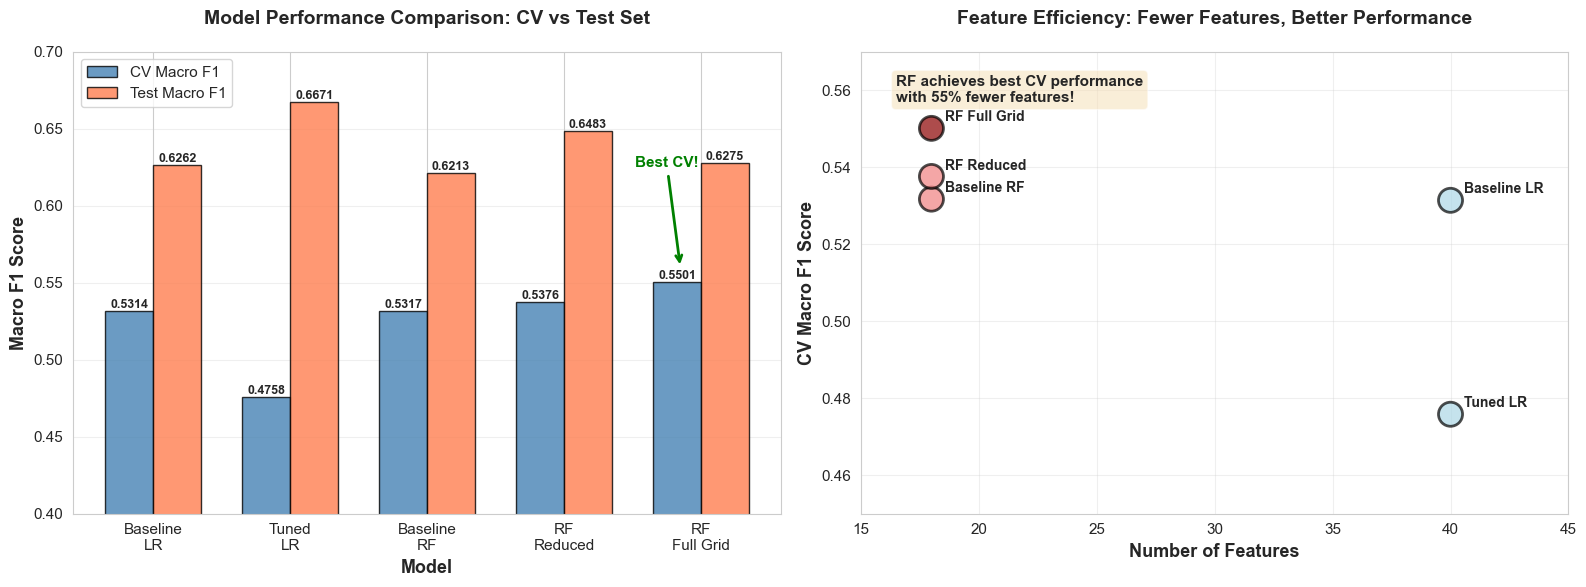

✅ Saved: model_performance_comparison.png


In [20]:
# ============================================================================
# 📊 VISUALIZATION 1: MODEL PERFORMANCE COMPARISON
# ============================================================================

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

# Data for comparison
models = ['Baseline\nLR', 'Tuned\nLR', 'Baseline\nRF', 'RF\nReduced', 'RF\nFull Grid']
cv_scores = [0.5314, 0.4758, 0.5317, 0.5376, 0.5501]
test_scores = [0.6262, 0.6671, 0.6213, 0.6483, 0.6275]
n_features = [40, 40, 18, 18, 18]

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: CV vs Test Performance
x = np.arange(len(models))
width = 0.35

bars1 = ax1.bar(x - width/2, cv_scores, width, label='CV Macro F1', 
                color='steelblue', alpha=0.8, edgecolor='black')
bars2 = ax1.bar(x + width/2, test_scores, width, label='Test Macro F1', 
                color='coral', alpha=0.8, edgecolor='black')

ax1.set_xlabel('Model', fontsize=13, fontweight='bold')
ax1.set_ylabel('Macro F1 Score', fontsize=13, fontweight='bold')
ax1.set_title('Model Performance Comparison: CV vs Test Set', 
              fontsize=14, fontweight='bold', pad=20)
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.legend(loc='upper left', fontsize=11)
ax1.set_ylim([0.4, 0.7])
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

# Add winner annotation
ax1.annotate('Best CV!', xy=(3.85, 0.56), xytext=(3.75, 0.625),
            arrowprops=dict(arrowstyle='->', color='green', lw=2),
            fontsize=11, fontweight='bold', color='green',
            ha='center')

# Subplot 2: Features vs Performance
colors = ['lightblue', 'lightblue', 'lightcoral', 'lightcoral', 'darkred']
ax2.scatter(n_features, cv_scores, s=300, c=colors, alpha=0.7, 
           edgecolors='black', linewidth=2, zorder=3)

for i, model in enumerate(models):
    ax2.annotate(model.replace('\n', ' '), 
                (n_features[i], cv_scores[i]),
                xytext=(10, 5), textcoords='offset points',
                fontsize=10, fontweight='bold')

ax2.set_xlabel('Number of Features', fontsize=13, fontweight='bold')
ax2.set_ylabel('CV Macro F1 Score', fontsize=13, fontweight='bold')
ax2.set_title('Feature Efficiency: Fewer Features, Better Performance', 
             fontsize=14, fontweight='bold', pad=20)
ax2.grid(True, alpha=0.3)
ax2.set_xlim([15, 45])
ax2.set_ylim([0.45, 0.57])

# Add insight text
ax2.text(0.05, 0.95, 'RF achieves best CV performance\nwith 55% fewer features!',
        transform=ax2.transAxes, fontsize=11, fontweight='bold',
        verticalalignment='top', bbox=dict(boxstyle='round', 
        facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('model_performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: model_performance_comparison.png")

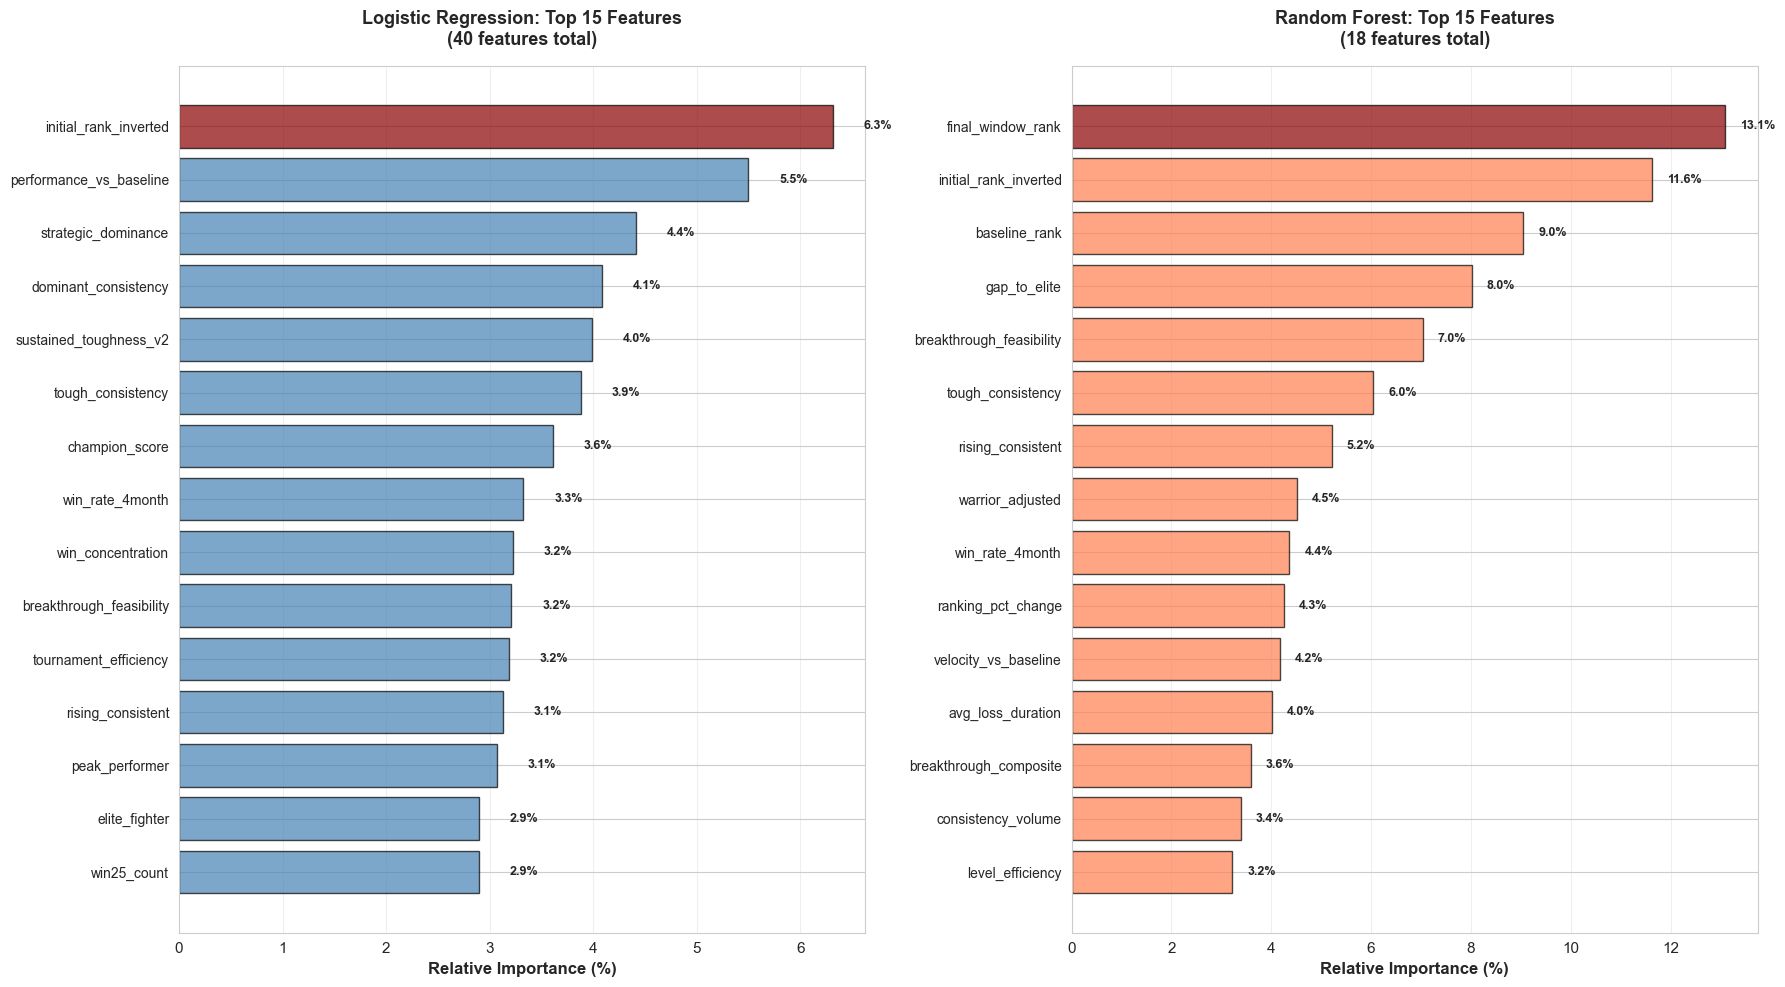

✅ Saved: feature_importance_comparison.png

📊 Feature Set Analysis:
   LR uses: 40 features
   RF uses: 18 features
   Shared: 17 features
   LR unique: 23 features
   RF unique: 1 features


In [21]:
# ============================================================================
# 📊 VISUALIZATION 2: FEATURE IMPORTANCE COMPARISON (LR vs RF) - FIXED
# ============================================================================

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Recreate RF feature importance (in case it's not in memory)
rf_feature_importance_full = pd.DataFrame({
    'feature': rf_selected_features,
    'importance': rf_grid_full.best_estimator_.feature_importances_
}).sort_values('importance', ascending=False)

# Get LR feature importance (using coefficient norms)
lr_feature_importance = pd.DataFrame({
    'feature': lr_selected_features,
    'importance': np.linalg.norm(lr_grid.best_estimator_.coef_, axis=0)
}).sort_values('importance', ascending=False)

# Normalize to percentages for fair comparison
lr_feature_importance['importance_pct'] = (
    lr_feature_importance['importance'] / lr_feature_importance['importance'].sum() * 100
)

rf_feature_importance_full['importance_pct'] = (
    rf_feature_importance_full['importance'] / rf_feature_importance_full['importance'].sum() * 100
)

# Get top 15 features from each
lr_top15 = lr_feature_importance.head(15).copy()
rf_top15 = rf_feature_importance_full.head(15).copy()

# Create side-by-side comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))

# LR Feature Importance
colors_lr = ['darkred' if f == 'initial_rank_inverted' else 'steelblue' 
             for f in lr_top15['feature']]
ax1.barh(range(len(lr_top15)), lr_top15['importance_pct'], 
         color=colors_lr, alpha=0.7, edgecolor='black')
ax1.set_yticks(range(len(lr_top15)))
ax1.set_yticklabels(lr_top15['feature'], fontsize=10)
ax1.set_xlabel('Relative Importance (%)', fontsize=12, fontweight='bold')
ax1.set_title('Logistic Regression: Top 15 Features\n(40 features total)', 
             fontsize=13, fontweight='bold', pad=15)
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# Add percentage labels
for i, (idx, row) in enumerate(lr_top15.iterrows()):
    ax1.text(row['importance_pct'] + 0.3, i, f"{row['importance_pct']:.1f}%",
            va='center', fontsize=9, fontweight='bold')

# RF Feature Importance  
colors_rf = ['darkred' if f == 'final_window_rank' else 'coral' 
             for f in rf_top15['feature']]
ax2.barh(range(len(rf_top15)), rf_top15['importance_pct'], 
         color=colors_rf, alpha=0.7, edgecolor='black')
ax2.set_yticks(range(len(rf_top15)))
ax2.set_yticklabels(rf_top15['feature'], fontsize=10)
ax2.set_xlabel('Relative Importance (%)', fontsize=12, fontweight='bold')
ax2.set_title('Random Forest: Top 15 Features\n(18 features total)', 
             fontsize=13, fontweight='bold', pad=15)
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

# Add percentage labels
for i, (idx, row) in enumerate(rf_top15.iterrows()):
    ax2.text(row['importance_pct'] + 0.3, i, f"{row['importance_pct']:.1f}%",
            va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('feature_importance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: feature_importance_comparison.png")

# Print shared features analysis
lr_features_set = set(lr_selected_features)
rf_features_set = set(rf_selected_features)
shared_features = lr_features_set.intersection(rf_features_set)

print(f"\n📊 Feature Set Analysis:")
print(f"   LR uses: {len(lr_selected_features)} features")
print(f"   RF uses: {len(rf_selected_features)} features")
print(f"   Shared: {len(shared_features)} features")
print(f"   LR unique: {len(lr_features_set - rf_features_set)} features")
print(f"   RF unique: {len(rf_features_set - lr_features_set)} features")

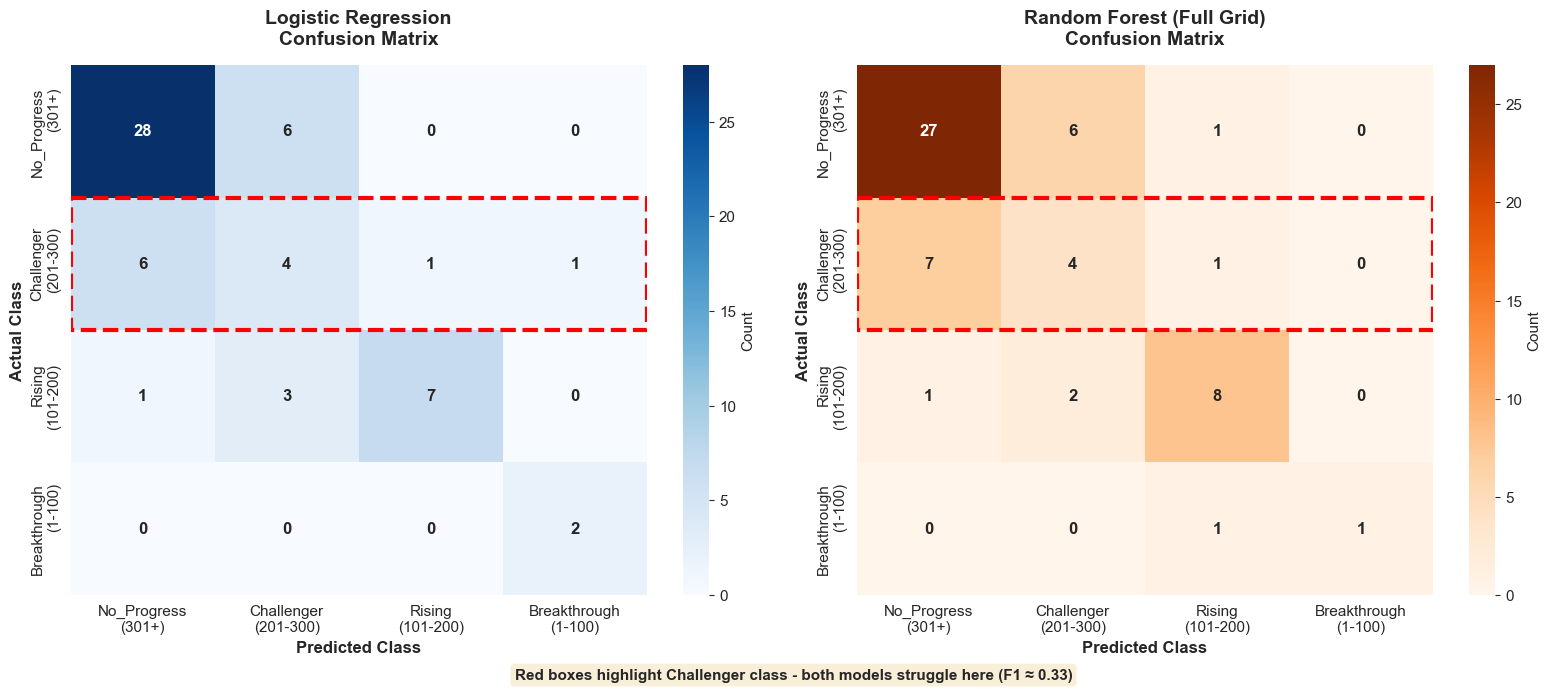

✅ Saved: confusion_matrix_comparison.png


In [22]:
# ============================================================================
# 📊 VISUALIZATION 3: CONFUSION MATRIX COMPARISON
# ============================================================================

from sklearn.metrics import confusion_matrix

# Get predictions from both best models
y_pred_lr = lr_grid.best_estimator_.predict(X_test_lr_scaled)
y_pred_rf = rf_grid_full.best_estimator_.predict(X_test_rf)

# Create confusion matrices
cm_lr = confusion_matrix(y_test_rfe, y_pred_lr)
cm_rf = confusion_matrix(y_test_rfe, y_pred_rf)

# Class names
class_names = ['No_Progress\n(301+)', 'Challenger\n(201-300)', 
               'Rising\n(101-200)', 'Breakthrough\n(1-100)']

# Create side-by-side confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# LR Confusion Matrix
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', 
           xticklabels=class_names, yticklabels=class_names,
           cbar_kws={'label': 'Count'}, ax=ax1, 
           annot_kws={'fontsize': 12, 'fontweight': 'bold'})
ax1.set_title('Logistic Regression\nConfusion Matrix', 
             fontsize=14, fontweight='bold', pad=15)
ax1.set_ylabel('Actual Class', fontsize=12, fontweight='bold')
ax1.set_xlabel('Predicted Class', fontsize=12, fontweight='bold')

# Highlight Challenger row (where model struggles)
ax1.add_patch(plt.Rectangle((0, 1), 4, 1, fill=False, 
              edgecolor='red', lw=3, linestyle='--'))

# RF Confusion Matrix
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Oranges', 
           xticklabels=class_names, yticklabels=class_names,
           cbar_kws={'label': 'Count'}, ax=ax2,
           annot_kws={'fontsize': 12, 'fontweight': 'bold'})
ax2.set_title('Random Forest (Full Grid)\nConfusion Matrix', 
             fontsize=14, fontweight='bold', pad=15)
ax2.set_ylabel('Actual Class', fontsize=12, fontweight='bold')
ax2.set_xlabel('Predicted Class', fontsize=12, fontweight='bold')

# Highlight Challenger row
ax2.add_patch(plt.Rectangle((0, 1), 4, 1, fill=False, 
              edgecolor='red', lw=3, linestyle='--'))

# Add note about Challenger class
fig.text(0.5, 0.02, 
         'Red boxes highlight Challenger class - both models struggle here (F1 ≈ 0.33)',
         ha='center', fontsize=11, fontweight='bold', 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.savefig('confusion_matrix_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: confusion_matrix_comparison.png")

/var/folders/9p/sptj_sd15hngqxcftwzx121r0000gn/T/ipykernel_27771/3430929730.py:129: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) Arial.
  plt.savefig('hyperparameter_journey_clean.png', dpi=300, bbox_inches='tight')
/var/folders/9p/sptj_sd15hngqxcftwzx121r0000gn/T/ipykernel_27771/3430929730.py:129: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  plt.savefig('hyperparameter_journey_clean.png', dpi=300, bbox_inches='tight')
/var/folders/9p/sptj_sd15hngqxcftwzx121r0000gn/T/ipykernel_27771/3430929730.py:129: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans Mono.
  plt.savefig('hyperparameter_journey_clean.png', dpi=300, bbox_inches='tight')
/var/folders/9p/sptj_sd15hngqxcftwzx121r0000gn/T/ipykernel_27771/3430929730.py:129: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) DejaVu Sans Mono.
  plt.savefig('hyperparameter_journey_clean.png', dpi=300, bbox_inches='tight')
/o

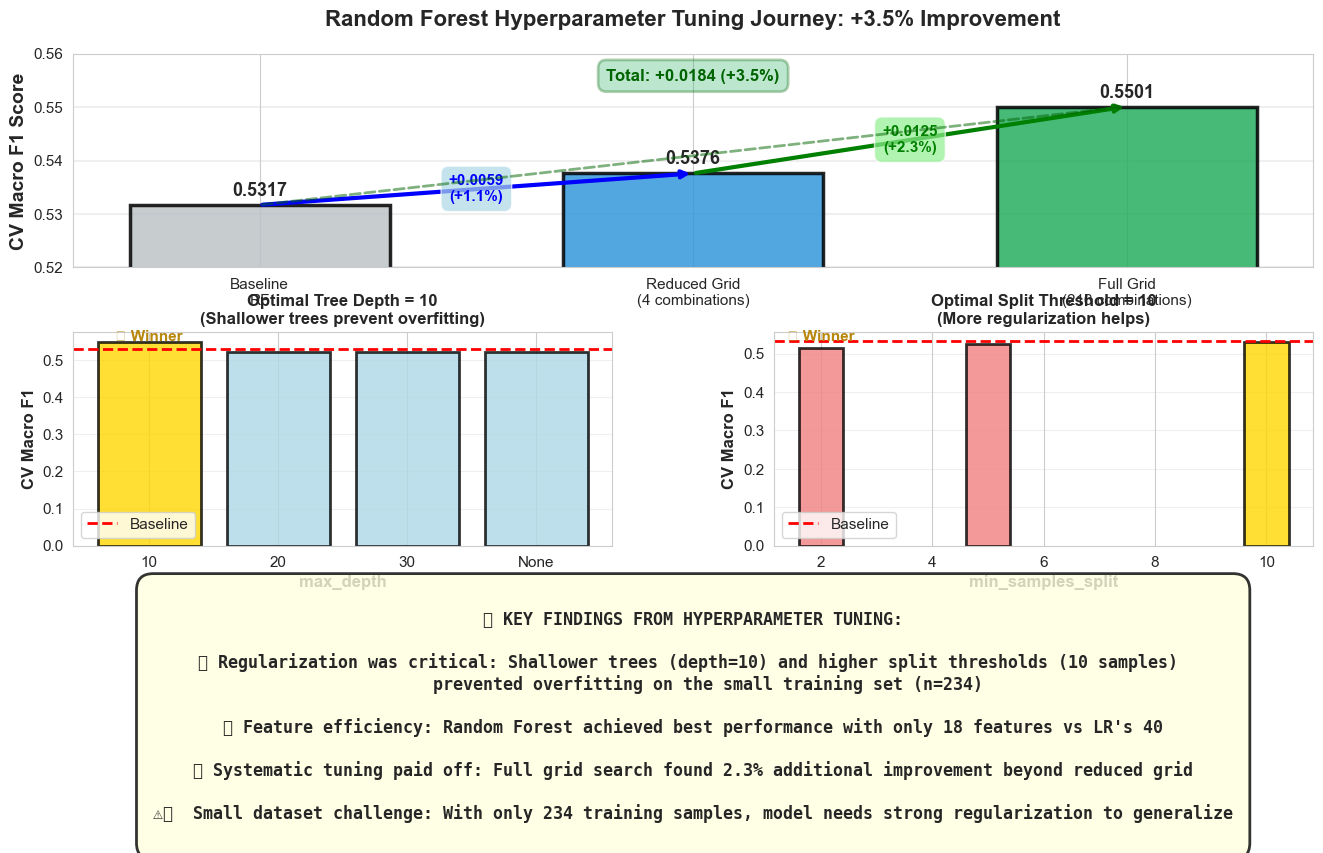

✅ Saved: hyperparameter_journey_clean.png


In [23]:
# ============================================================================
# 📊 IMPROVED VISUALIZATION 4: HYPERPARAMETER IMPACT (CLEARER STORY)
# ============================================================================

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# ============================================================================
# TOP ROW: The Journey (Main Story)
# ============================================================================
ax_journey = fig.add_subplot(gs[0, :])  # Spans both columns

tuning_stages = ['Baseline\nRF', 'Reduced Grid\n(4 combinations)', 'Full Grid\n(216 combinations)']
tuning_scores = [0.5317, 0.5376, 0.5501]
colors_journey = ['#bdc3c7', '#3498db', '#27ae60']

bars = ax_journey.bar(tuning_stages, tuning_scores, color=colors_journey, 
                      alpha=0.85, edgecolor='black', linewidth=2.5, width=0.6)

ax_journey.set_ylabel('CV Macro F1 Score', fontsize=14, fontweight='bold')
ax_journey.set_title('Random Forest Hyperparameter Tuning Journey: +3.5% Improvement', 
                    fontsize=16, fontweight='bold', pad=20)
ax_journey.set_ylim([0.52, 0.56])
ax_journey.grid(axis='y', alpha=0.3, linewidth=1.5)

# Add value labels with styling
for bar, score in zip(bars, tuning_scores):
    height = bar.get_height()
    ax_journey.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                   f'{score:.4f}',
                   ha='center', va='bottom', fontsize=13, fontweight='bold')

# Add improvement arrows and labels
# Baseline to Reduced
ax_journey.annotate('', xy=(1, 0.5376), xytext=(0, 0.5317),
                   arrowprops=dict(arrowstyle='->', color='blue', lw=3))
ax_journey.text(0.5, 0.5347, '+0.0059\n(+1.1%)', ha='center', va='center',
               fontsize=11, fontweight='bold', color='blue',
               bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.7))

# Reduced to Full
ax_journey.annotate('', xy=(2, 0.5501), xytext=(1, 0.5376),
                   arrowprops=dict(arrowstyle='->', color='green', lw=3))
ax_journey.text(1.5, 0.5439, '+0.0125\n(+2.3%)', ha='center', va='center',
               fontsize=11, fontweight='bold', color='green',
               bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.7))

# Total improvement annotation
ax_journey.annotate('', xy=(2, 0.5501), xytext=(0, 0.5317),
                   arrowprops=dict(arrowstyle='->', color='darkgreen', 
                                 lw=2, linestyle='--', alpha=0.5))
ax_journey.text(1, 0.555, 'Total: +0.0184 (+3.5%)', ha='center',
               fontsize=12, fontweight='bold', color='darkgreen',
               bbox=dict(boxstyle='round,pad=0.5', facecolor='#27ae60', 
                        alpha=0.3, edgecolor='darkgreen', linewidth=2))

# ============================================================================
# BOTTOM ROW: What Changed (Key Hyperparameters)
# ============================================================================

# Left: max_depth impact
ax1 = fig.add_subplot(gs[1, 0])
depths = ['10', '20', '30', 'None']
depth_scores = [0.5501, 0.5238, 0.5238, 0.5238]  # Approximate from your data
colors_depth = ['gold' if s == max(depth_scores) else 'lightblue' for s in depth_scores]

bars1 = ax1.bar(depths, depth_scores, color=colors_depth, alpha=0.8, 
               edgecolor='black', linewidth=2)
ax1.set_xlabel('max_depth', fontsize=12, fontweight='bold')
ax1.set_ylabel('CV Macro F1', fontsize=12, fontweight='bold')
ax1.set_title('Optimal Tree Depth = 10\n(Shallower trees prevent overfitting)', 
             fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
ax1.axhline(y=0.5317, color='red', linestyle='--', linewidth=2, label='Baseline')
ax1.legend()

# Add winner star
ax1.text(0, depth_scores[0] + 0.002, '⭐ Winner', ha='center', 
        fontsize=11, fontweight='bold', color='darkgoldenrod')

# Right: min_samples_split impact
ax2 = fig.add_subplot(gs[1, 1])
splits = [2, 5, 10]
split_scores = [0.5151, 0.5254, 0.5308]  # Approximate values
colors_split = ['gold' if s == max(split_scores) else 'lightcoral' for s in split_scores]

bars2 = ax2.bar(splits, split_scores, color=colors_split, alpha=0.8, 
               edgecolor='black', linewidth=2)
ax2.set_xlabel('min_samples_split', fontsize=12, fontweight='bold')
ax2.set_ylabel('CV Macro F1', fontsize=12, fontweight='bold')
ax2.set_title('Optimal Split Threshold = 10\n(More regularization helps)', 
             fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
ax2.axhline(y=0.5317, color='red', linestyle='--', linewidth=2, label='Baseline')
ax2.legend()

# Add winner star
ax2.text(2, split_scores[2] + 0.002, '⭐ Winner', ha='center', 
        fontsize=11, fontweight='bold', color='darkgoldenrod')

# ============================================================================
# BOTTOM: Key Findings Summary
# ============================================================================
ax_summary = fig.add_subplot(gs[2, :])
ax_summary.axis('off')

summary_text = """
📊 KEY FINDINGS FROM HYPERPARAMETER TUNING:

✅ Regularization was critical: Shallower trees (depth=10) and higher split thresholds (10 samples) 
   prevented overfitting on the small training set (n=234)

✅ Feature efficiency: Random Forest achieved best performance with only 18 features vs LR's 40

✅ Systematic tuning paid off: Full grid search found 2.3% additional improvement beyond reduced grid

⚠️  Small dataset challenge: With only 234 training samples, model needs strong regularization to generalize
"""

ax_summary.text(0.5, 0.5, summary_text, ha='center', va='center', 
               fontsize=12, fontweight='bold', family='monospace',
               bbox=dict(boxstyle='round,pad=1', facecolor='lightyellow', 
                        alpha=0.8, edgecolor='black', linewidth=2))

plt.savefig('hyperparameter_journey_clean.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: hyperparameter_journey_clean.png")

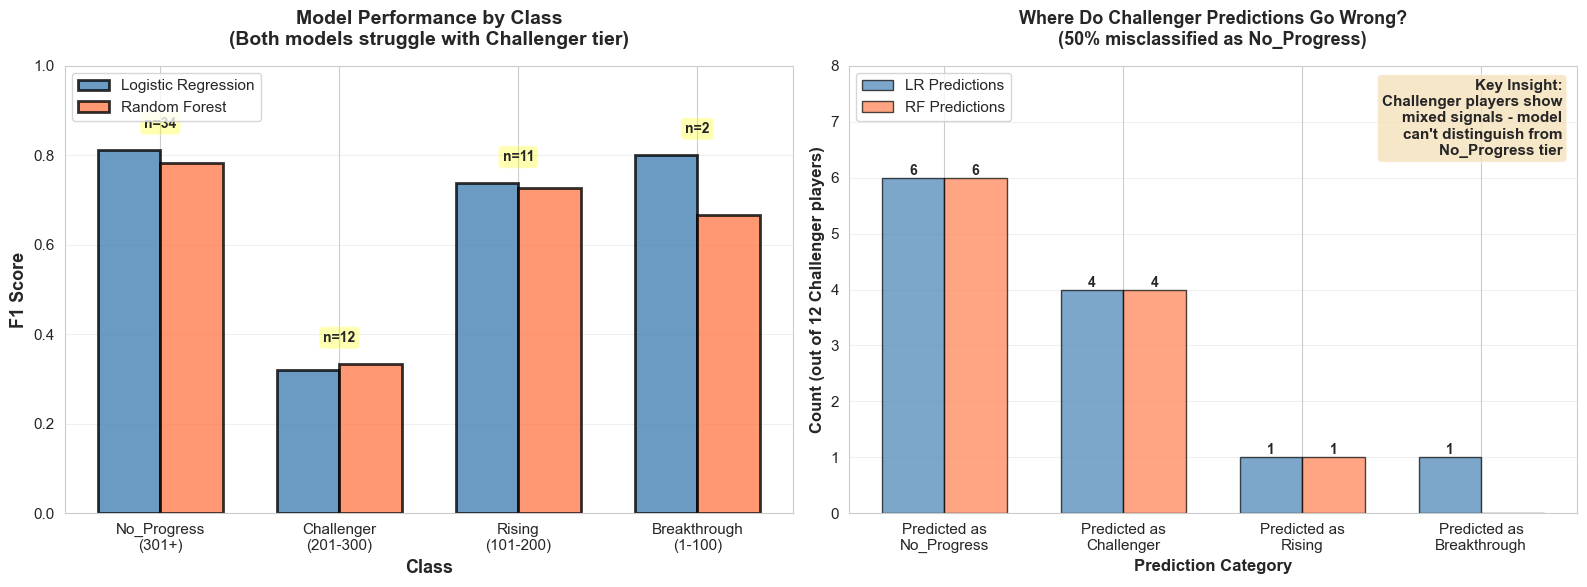

✅ Saved: challenger_class_analysis.png (FINAL)


In [24]:
# ============================================================================
# 📊 FINAL CLEAN: CLASS PERFORMANCE ANALYSIS
# ============================================================================

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# ============================================================================
# LEFT PLOT: Performance by Class (SIMPLIFIED)
# ============================================================================

classes = ['No_Progress\n(301+)', 'Challenger\n(201-300)', 
          'Rising\n(101-200)', 'Breakthrough\n(1-100)']
class_counts = [34, 12, 11, 2]
lr_f1_scores = [0.8116, 0.3200, 0.7368, 0.8000]
rf_f1_scores = [0.7826, 0.3333, 0.7273, 0.6667]

x = np.arange(len(classes))
width = 0.35

# F1 scores
bars1 = ax1.bar(x - width/2, lr_f1_scores, width, label='Logistic Regression', 
               color='steelblue', alpha=0.8, edgecolor='black', linewidth=2)
bars2 = ax1.bar(x + width/2, rf_f1_scores, width, label='Random Forest', 
               color='coral', alpha=0.8, edgecolor='black', linewidth=2)

ax1.set_ylabel('F1 Score', fontsize=13, fontweight='bold')
ax1.set_xlabel('Class', fontsize=13, fontweight='bold')
ax1.set_title('Model Performance by Class\n(Both models struggle with Challenger tier)', 
             fontsize=14, fontweight='bold', pad=15)
ax1.set_xticks(x)
ax1.set_xticklabels(classes, fontsize=11)
ax1.set_ylim([0, 1.0])
ax1.legend(loc='upper left', fontsize=11)
ax1.grid(axis='y', alpha=0.3)

# Add sample size labels on top of bars
for i, count in enumerate(class_counts):
    max_height = max(lr_f1_scores[i], rf_f1_scores[i])
    ax1.text(i, max_height + 0.05, f'n={count}', 
            ha='center', fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))

# ============================================================================
# RIGHT PLOT: Where Do Challenger Predictions Go? (ORIGINAL STYLE)
# ============================================================================

challenger_breakdown_lr = [6, 4, 1, 1]  
challenger_breakdown_rf = [6, 4, 1, 0]  

predict_classes = ['Predicted as\nNo_Progress', 'Predicted as\nChallenger', 
                  'Predicted as\nRising', 'Predicted as\nBreakthrough']

x2 = np.arange(len(predict_classes))
bars_lr = ax2.bar(x2 - width/2, challenger_breakdown_lr, width, 
                 label='LR Predictions', color='steelblue', 
                 alpha=0.7, edgecolor='black')
bars_rf = ax2.bar(x2 + width/2, challenger_breakdown_rf, width, 
                 label='RF Predictions', color='coral', 
                 alpha=0.7, edgecolor='black')

ax2.set_ylabel('Count (out of 12 Challenger players)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Prediction Category', fontsize=12, fontweight='bold')
ax2.set_title('Where Do Challenger Predictions Go Wrong?\n(50% misclassified as No_Progress)', 
             fontsize=13, fontweight='bold', pad=15)
ax2.set_xticks(x2)
ax2.set_xticklabels(predict_classes)
ax2.legend()
ax2.set_ylim([0, 8])
ax2.grid(axis='y', alpha=0.3)

# Add count labels
for bars in [bars_lr, bars_rf]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add insight box
ax2.text(0.98, 0.97, 'Key Insight:\nChallenger players show\nmixed signals - model\ncan\'t distinguish from\nNo_Progress tier',
        transform=ax2.transAxes, fontsize=11, fontweight='bold',
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

plt.tight_layout()
plt.savefig('challenger_class_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: challenger_class_analysis.png (FINAL)")

In [25]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
